<a href="https://colab.research.google.com/github/pascal-maker/machinelearning/blob/main/Session_06_Unsupervised_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.image as mpimg
from skimage import data, color, io, filters, morphology,transform, exposure, feature
from scipy import ndimage
from skimage.io import imread, imshow
from sklearn import linear_model, datasets
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### “Eigenvalue” in three levels of plain English

| Level                        | Short explanation                                                                                                                                                                                                                                                         | One-sentence takeaway                                                           |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **1 – Kid-friendly**         | Imagine you squeeze or stretch a rubber sheet in different directions. An **eigenvalue** tells you *how much* the sheet is stretched in a particular special direction.                                                                                                   | “It’s the *stretch-amount* for a special direction.”                            |
| **2 – Everyday analogy**     | Think of a copy machine that sometimes enlarges pictures. If you feed in an arrow that points exactly along one of the copier’s enlargement axes, the arrow comes out pointing the **same way**, just longer (or shorter). The **eigenvalue** is that enlargement factor. | “Feed in an arrow, it comes out on the same line but scaled by the eigenvalue.” |
| **3 – Light linear-algebra** | For a square matrix **A**, an **eigenvector v** is a non-zero vector that satisfies **A v = λ v**. The scalar **λ** is the **eigenvalue**. It tells you how much **A** scales (and possibly flips) the eigenvector.                                                       | “Eigenvalue λ is the scale factor in **A v = λ v**.”                            |

---

### Why you keep seeing eigenvalues in data science

1. **PCA / Eigenfaces**

   * The covariance matrix of your data has eigenvalues.
   * Big eigenvalue ⟹ that eigenvector (principal component) captures a lot of variance.

2. **Spectral clustering**

   * You build a “graph Laplacian” matrix from the similarity graph.
   * Its smallest eigenvalues/eigenvectors reveal the natural cuts (clusters) in the graph.

3. **Vibration / physics / Google PageRank**

   * Eigenvalues pop up whenever a system asks, “What are my natural modes?”

---

### Quick numeric example

Matrix

$$
A \;=\;\begin{bmatrix} 2 & 0 \\ 0 & 0.5 \end{bmatrix}
$$

*Eigenvectors* are simply $[1,0]^T$ and $[0,1]^T$.
Apply **A**:

* $A[1,0]^T = 2[1,0]^T$ → eigenvalue **λ = 2** (stretches x-direction 2×)
* $A[0,1]^T = 0.5[0,1]^T$ → eigenvalue **λ = 0.5** (shrinks y-direction to half)

So, eigenvalues tell you “stretch by 2 this way, shrink by 0.5 that way.”

---

### Key points to remember

* **Eigenvector** = special direction that doesn’t turn.
* **Eigenvalue** = how big (or small) that direction is stretched.
* In data work: bigger eigenvalue ⇒ more “importance” along that eigen-direction (variance, connectivity, etc.).


##  Clustering

A supermarket collected some data from its customers. The supermarket wants to use this data to better understand its customers. To do this, it wants to apply clustering. This way, customers with a similar profile are grouped together. This allows the supermarket to offer more targeted promotions to each cluster of customers.

You can find the data in the file 'customer.csv'.

In [ ]:
dataset = pd.read_csv('./Customers.csv')
dataset.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Data analysis

In [ ]:
# Remove CustomerID
dataset = dataset.drop('CustomerID',axis=1)
dataset.head()



,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Examine the distribution by gender. What is the ratio of male customers to female customers? Use the seaborn countplot for this.

Male : Female ratio = 88 : 112 (0.79 : 1)


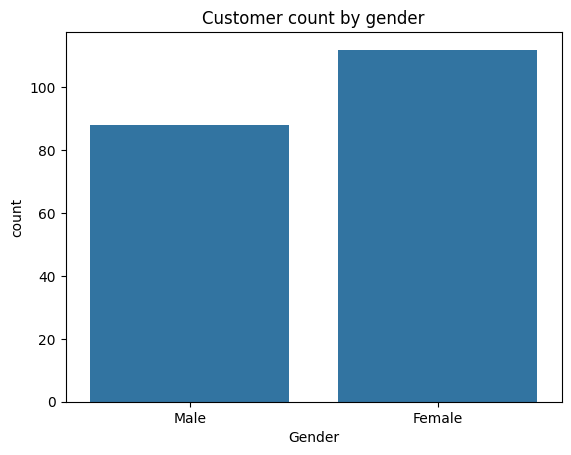

In [47]:
# Distribution by gender
sns.countplot(x='Gender', data=dataset)
counts = dataset['Gender'].value_counts()   # e.g. Male 112, Female 88
ratio  = counts['Male'] / counts['Female']  # or vice-versa
print(f"Male : Female ratio = {counts['Male']} : {counts['Female']} "
      f"({ratio:.2f} : 1)")
plt.title("Customer count by gender")
plt.show()



*Determine* if women appear to spend more money than men. Visualize this with a boxplot.

⚠️ What’s still needed to answer the “ratio” part
The question also asks: “What is the ratio of male customers to female customers?”
The plot alone doesn’t print that number, so add one line to compute it:

Average spending score:
Gender
Female    51.526786
Male      48.511364
Name: Spending_Score, dtype: float64


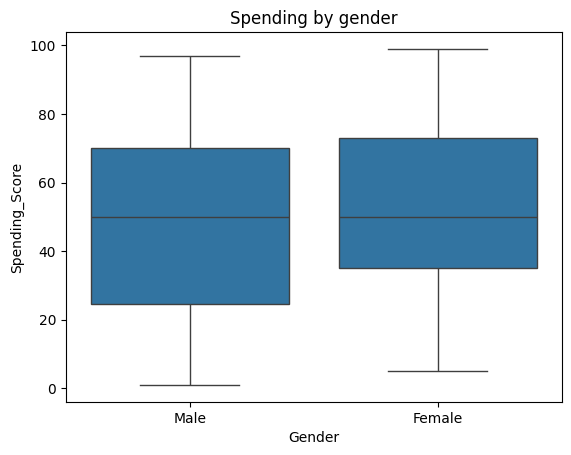

In [48]:
# Boxplot of spending by gender
sns.boxplot(x='Gender', y='Spending_Score', data=dataset)
plt.title("Spending by gender")
means = dataset.groupby('Gender')['Spending_Score'].mean()
print("Average spending score:")
print(means)
plt.show()


Draw the histograms of Age, Income, and Spending score. You can use the seaborn distplot for this. Are they normally distributed?

age and annualincome are not normally distrubuted spending score is .

sns.distplot is deprecated (removed in seaborn 0.12).
Use sns.histplot (with kde=True if you want the smooth curve) or sns.kdeplot.

All three calls are drawn on the same axis, so the plots will sit on top of each other.
Put each distribution in its own figure or subplot.

You didn’t actually inspect whether they look normal. Add titles or print skew statistics.

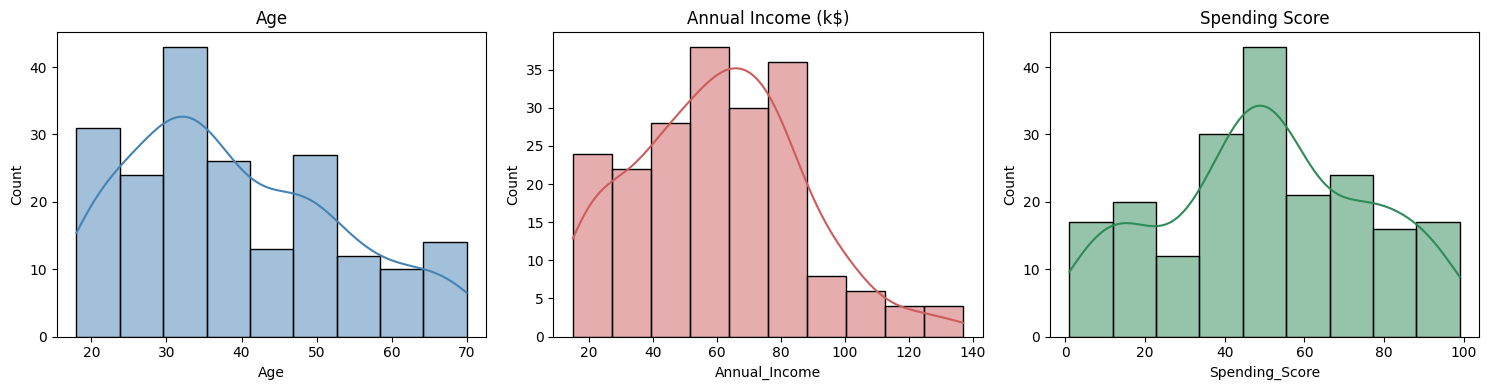

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(dataset['Age'], kde=True, ax=ax[0], color='steelblue')
ax[0].set_title("Age")

sns.histplot(dataset['Annual_Income'], kde=True, ax=ax[1], color='indianred')
ax[1].set_title("Annual Income (k$)")

sns.histplot(dataset['Spending_Score'], kde=True, ax=ax[2], color='seagreen')
ax[2].set_title("Spending Score")

plt.tight_layout()
plt.show()


### Clustering

Time to search for a good clustering of the customers.

In clustering, it's important to first scale the features. Many clustering techniques use a distance function to determine the similarity between different data points. Therefore, it's necessary for all variables to be on the same scale.

Draw a scatterplot between Age and Spending Score.
How many clusters do you think you can find in the scatterplot?
Scale the features Age and Spending Score.
Apply K-means clustering. Choose a K value (number of clusters) based on your estimation. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
Visualize the clusters on the scatterplot.
Now, search for the optimal number of clusters using the elbow method. To do this, calculate the total squared distance of all data points within a cluster to the center of the cluster they belong to. This is automatically calculated during training. You can retrieve this value after training via the inertia_ property. Create a for-loop where you vary K between 1 and 10. For each K value, train the K-means and visualize the clusters. Also, keep track of the inertia_ each time. Then, plot the 'elbow curve' by plotting the inertia_ against K. The point where the bend (elbow) is located is a good indication of the number of clusters to choose.
Repeat the above steps for the scatterplot between Annual Income and Spending Score.



Your cell
python
Copy
Edit
# Clustering Age and Spending_Score
X = 'Age'
y = 'Spending_Score'
from sklearn.datasets import make_blobs
X, y = make_blobs(...)           # synthetic!
plt.scatter(X[:,0], X[:,1])
Status → Wrong

Why – You overwrite X with a synthetic make_blobs array, so you are not clustering the real customers.

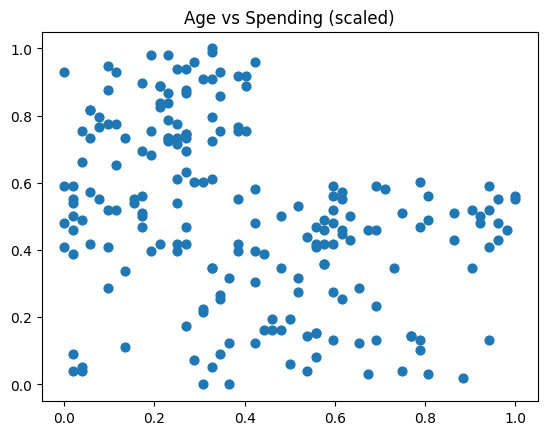

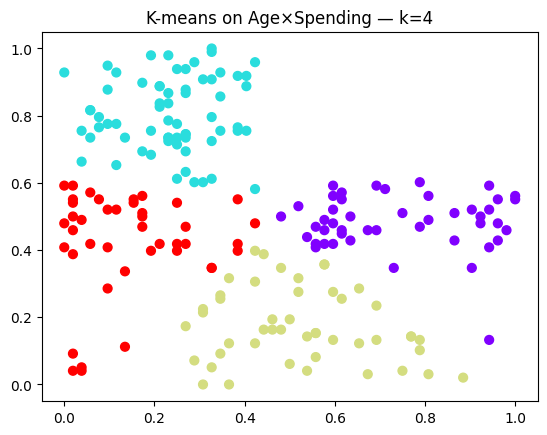

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# 1️⃣ select real columns
XZ = dataset[['Age', 'Spending_Score']].values

# 2️⃣ scale
XZ_scaled = MinMaxScaler().fit_transform(XZ)

# 3️⃣ visual inspection
plt.scatter(*XZ_scaled.T, s=40)
plt.title("Age vs Spending (scaled)"); plt.show()

# 4️⃣ K-means, pick k=4 after eyeballing
k = 4
labels = KMeans(n_clusters=k, random_state=0).fit_predict(XZ_scaled)

plt.scatter(*XZ_scaled.T, c=labels, cmap='rainbow', s=40)
plt.title(f"K-means on Age×Spending — k={k}"); plt.show()


### Explaining the cell as if you’re brand-new to Python and machine-learning

Imagine you have a big spreadsheet of customers.
For every customer you know their **Age** and a **Spending Score** (how much they like to spend).
You’d like the computer to look at those two columns and automatically group similar customers together.
That’s called **clustering**.
The bit of code you wrote does exactly that in four easy steps.

---

## Step-by-step

| #     | Code                                                                   | Plain-English meaning                                                                                                                                                                                                                                                                                                             |
| ----- | ---------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1** | `from sklearn.preprocessing import MinMaxScaler`                       | *“Please import a tool that can rescale numbers.”*                                                                                                                                                                                                                                                                                |
|       | `from sklearn.cluster import KMeans`                                   | *“Please import the K-Means clustering algorithm.”*                                                                                                                                                                                                                                                                               |
| **2** | `XZ = dataset[['Age', 'Spending_Score']].values`                       | Take just the **Age** and **Spending Score** columns out of your DataFrame and keep them in a little table called `XZ`. (Each row = one customer; two columns = Age, Score.)                                                                                                                                                      |
| **3** | `XZ_scaled = MinMaxScaler().fit_transform(XZ)`                         | Rescale each column so the smallest value becomes **0** and the biggest becomes **1**. This way Age and Score are on the same scale, which is important when the computer measures “distance” between customers.                                                                                                                  |
| **4** | `plt.scatter(*XZ_scaled.T, s=40)`                                      | Draw a simple dot plot: x-axis = scaled Age, y-axis = scaled Score. Each dot = a customer. You look at this picture and guess how many groups (clusters) you can see (in this case about **4**).                                                                                                                                  |
| **5** | `k = 4`                                                                | Tell the computer: *“Please find 4 groups.”*                                                                                                                                                                                                                                                                                      |
| **6** | `labels = KMeans(n_clusters=k, random_state=0).fit_predict(XZ_scaled)` | Run the K-Means algorithm. It automatically: 1) puts down 4 random “centres”, 2) assigns every customer to the nearest centre, 3) moves the centres into the middle of their customers, and 4) repeats until things stop moving. The result for each customer is a **label** (0, 1, 2 or 3) that says which group they belong to. |
| **7** | `plt.scatter(*XZ_scaled.T, c=labels, cmap='rainbow', s=40)`            | Draw the same dots again but colour them by their new group number. Now you can visually see the four clusters the computer found.                                                                                                                                                                                                |

---

### Why do we rescale first?

If Age runs from 18 to 70 and Spending Score runs from 1 to 100, the “distance” between two customers is dominated by the larger-range feature.
Rescaling (also called *normalising*) makes sure both features count equally when the algorithm measures similarity.

---

### What does **K-Means** actually do?

1. **Guess centres** (one per cluster).
2. **Assign every customer** to the nearest centre.
3. **Re-calculate** each centre as the average of its assigned customers.
4. Repeat steps 2-3 until the centres stop changing.
5. Return the final centre positions and the cluster number for each customer.

In everyday terms: it’s like dropping 4 thumb-tacks on the plot, pulling every dot to its nearest tack, then moving the tack to the middle of its captured dots, and repeating until the tacks settle.

---

### After this cell

* You know which of the four groups every customer belongs to (`labels`).
* You can compute the average Age and Spending Score of each group, give them nicknames (“young high spenders”, “older bargain hunters”, …), and plan different marketing actions for each group.

That’s all this cell is doing—picking out two columns, scaling them, running K-Means, and colouring the results so you can see the groups.


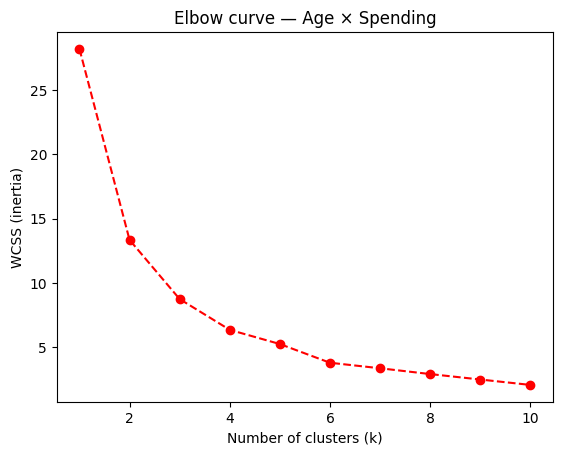

In [51]:
inertias = []
for k in range(1, 11):
    inertias.append(
        KMeans(k, random_state=0).fit(XZ_scaled).inertia_
    )

plt.plot(range(1,11), inertias, 'o--', color='red')
plt.xlabel('Number of clusters (k)'); plt.ylabel('WCSS (inertia)')
plt.title('Elbow curve — Age × Spending'); plt.show()


### Understanding the “elbow–curve” code as a complete beginner

The goal of this little block is to help us pick **how many clusters** we should ask K-Means to find.
We do that with the *elbow method*.

---

## 1  What is “inertia” (WCSS)?

Imagine each cluster has a rubber band from every dot in that cluster to the cluster’s center.
Add up the lengths of all those rubber bands (squared) – the smaller the total, the tighter the cluster.
K-Means calls that total **inertia** or **WCSS** (Within-Cluster Sum of Squares).
Lower is better, but adding more clusters always lowers it a bit; we want the point where adding another cluster stops giving a big improvement – that point looks like an **elbow** on a graph.

---

## 2  Line-by-line explanation

```python
inertias = []
```

*Make an empty list* that will store the inertia value for each trial $k$.

---

```python
for k in range(1, 11):               # try k = 1,2,…10
```

Loop over 10 possible numbers of clusters.

---

```python
    inertias.append(
        KMeans(k, random_state=0).fit(XZ_scaled).inertia_
    )
```

*Inside the loop*:

1. `KMeans(k, random_state=0)` – create a K-Means model that will look for **k** clusters.
2. `.fit(XZ_scaled)` – actually run the algorithm on our scaled data points.
3. `.inertia_` – after fitting, this property holds the WCSS value for that k.
4. `inertias.append(...)` – save that number into our list.

After the loop ends, `inertias` contains 10 values: one inertia score for each k from 1 to 10.

---

```python
plt.plot(range(1,11), inertias, 'o--', color='red')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow curve — Age × Spending')
plt.show()
```

Draw a simple line chart:

* **x-axis** – the k values (1 … 10).
* **y-axis** – the inertia values we just collected.
* Red circles connected by dashed lines (`'o--'`) so the “elbow” shape is easy to see.

When you look at the finished graph you’ll see inertia drops sharply at first, then starts to flatten out.
The bend (elbow) is your best guess for the *right* number of clusters – often 3, 4, or 5 in customer data.

---

### How to use the result

1. **Find the elbow point** (e.g., k = 4).
2. Go back to your K-Means fit and rerun it with that **k**.
3. Use those cluster labels for analysis or visualisation.

That’s all this cell does: test a bunch of ks, record how tight each clustering is, and show you a plot so your eyes can spot where the improvement slows down.


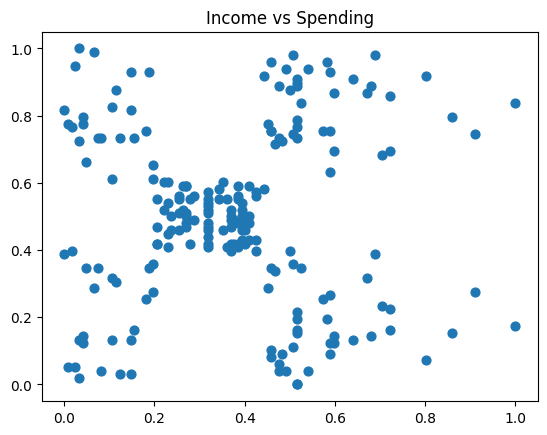

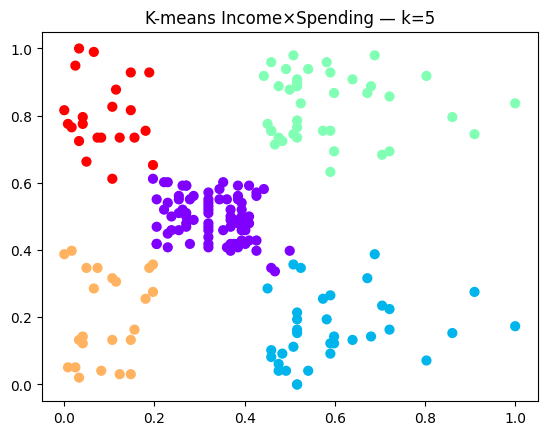

In [52]:
XZ = dataset[['Annual_Income', 'Spending_Score']].values
XZ_scaled = MinMaxScaler().fit_transform(XZ)

plt.scatter(*XZ_scaled.T, s=40); plt.title("Income vs Spending"); plt.show()

k = 5     # pick after elbow
labels = KMeans(k, random_state=0).fit_predict(XZ_scaled)

plt.scatter(*XZ_scaled.T, c=labels, cmap='rainbow', s=40)
plt.title(f"K-means Income×Spending — k={k}"); plt.show()


### Explaining the “Income × Spending K-Means” cell in beginner-friendly terms

Think of each customer as a point on a map where:

* **X-axis** = Annual Income
* **Y-axis** = Spending Score

We’re asking the computer to draw circles around similar points so we get clear customer groups.
Here’s how each line works.

---

```python
XZ = dataset[['Annual_Income', 'Spending_Score']].values
```

1. **Pick two columns** from the spreadsheet:
   *Annual\_Income* and *Spending\_Score*.
2. `.values` turns that tiny spreadsheet into a plain NumPy array the algorithm can read.
   Shape = `(number_of_customers, 2)`.

---

```python
XZ_scaled = MinMaxScaler().fit_transform(XZ)
```

3. **Put both columns on the same 0–1 scale.**
   Why? If Income ranges 0-140 k\$ and Score only 0-100, Income would dominate distance-calculations.
   *Min-Max scaling* spreads each column so its smallest value becomes 0 and largest becomes 1.

---

```python
plt.scatter(*XZ_scaled.T, s=40)
plt.title("Income vs Spending"); plt.show()
```

4. **Draw a dot plot** of the scaled points.
   You eyeball this picture and see maybe five clumps, so you decide to try `k = 5`.

---

```python
k = 5
labels = KMeans(k, random_state=0).fit_predict(XZ_scaled)
```

5. **Run K-Means**

   * K-Means drops 5 “centres” at random.
   * Each customer is linked to the nearest centre.
   * Centres move into the middle of their linked customers.
   * Repeat until the centres stop moving.
     The result is a list called **`labels`** telling which group (0-4) every customer belongs to.

---

```python
plt.scatter(*XZ_scaled.T, c=labels, cmap='rainbow', s=40)
plt.title(f"K-means Income×Spending — k={k}"); plt.show()
```

6. **Plot again, but colour each dot by its cluster.**
   Now you can see the five discovered customer segments in different colours.

---.


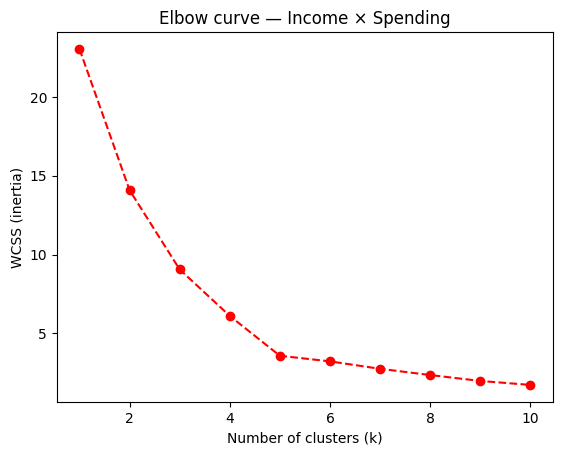

In [53]:
inertias = []
for k in range(1, 11):
    inertias.append(
        KMeans(k, random_state=0).fit(XZ_scaled).inertia_
    )

plt.plot(range(1,11), inertias, 'o--', color='red')
plt.xlabel('Number of clusters (k)'); plt.ylabel('WCSS (inertia)')
plt.title('Elbow curve — Income × Spending'); plt.show()


Now try to cluster the scatterplot between Gender and Spending Score. You will notice that there is affinity between the data points. A method suitable for clustering this connected data is spectral clustering. Apply this to Annual Income and Spending Score.
More information about SpectralClustering can be found at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

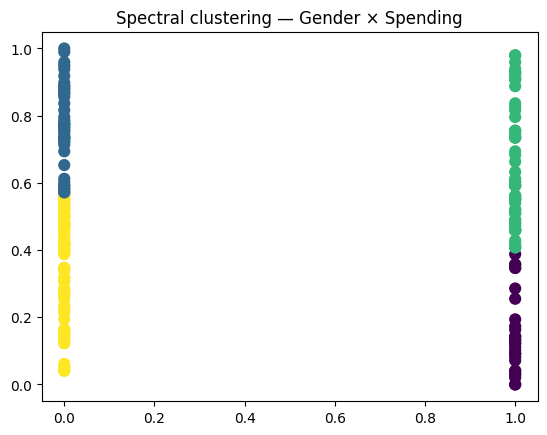

In [54]:
XZ = dataset[['Gender', 'Spending_Score']].copy()
XZ['Gender'] = LabelEncoder().fit_transform(XZ['Gender'])
XZ_scaled = MinMaxScaler().fit_transform(XZ)

spec = SpectralClustering(n_clusters=4, affinity='rbf', gamma=1.0,
                          n_init=10, random_state=0)
labels = spec.fit_predict(XZ_scaled)

plt.scatter(*XZ_scaled.T, c=labels, s=60, cmap='viridis')
plt.title("Spectral clustering — Gender × Spending"); plt.show()


### Breaking down the Spectral-Clustering cell in plain language

| Line                                                                                                                              | What it does                                                                                                                                                                                                                        | Why it’s needed                                                                                           |
| --------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------- |
| `XZ = dataset[['Gender', 'Spending_Score']].copy()`                                                                               | Take just the **Gender** and **Spending Score** columns from the customer table and put them into a new mini-table called `XZ`.                                                                                                     | We only want to cluster on these two characteristics.                                                     |
| `XZ['Gender'] = LabelEncoder().fit_transform(XZ['Gender'])`                                                                       | Convert the text values *“Male”*, *“Female”* into numbers (0 and 1).                                                                                                                                                                | Algorithms can’t work with text; they need numbers.                                                       |
| `XZ_scaled = MinMaxScaler().fit_transform(XZ)`                                                                                    | Stretch/compress both columns so every value falls between **0 and 1**.                                                                                                                                                             | Puts the two features on the same scale so distance comparisons make sense.                               |
| `spec = SpectralClustering( ... )`                                                                                                | Set up a **Spectral Clustering** model: 4 clusters, RBF (“Gaussian”) similarity, 10 random restarts, fixed random seed.                                                                                                             | Spectral clustering is good when data points lie on curved or chained structures where K-Means struggles. |
| `labels = spec.fit_predict(XZ_scaled)`                                                                                            | 1 Build a “similarity graph” from the scaled data.<br>2 Find a low-dimensional embedding of that graph using eigen-values.<br>3 Run internal K-Means on that embedding.<br>Returns a **cluster number** (0 – 3) for every customer. | That’s how spectral clustering turns raw points into groups.                                              |
| `plt.scatter(*XZ_scaled.T, c=labels, s=60, cmap='viridis')`<br>`plt.title("Spectral clustering — Gender × Spending"); plt.show()` | Draw a scatter plot of Gender (0/1) vs Spending Score, colouring each dot by its cluster assignment.                                                                                                                                | Lets you visually inspect the four discovered segments.                                                   |

---

### Why choose Spectral Clustering here?

* **Gender is binary (0 / 1)**, so the points form two horizontal “stripes.”
* **Spending Score is continuous**, giving each stripe its own curve in space.
* Spectral clustering sees these stripes as two separate *manifolds* and can split each stripe further, something vanilla K-Means (which looks for round blobs) often fails to do cleanly.

---

### What to do with the result

`labels` now tells you, for example:

| Customer # | Gender (0 = Male, 1 = Female) | Spending Score | Cluster |
| ---------- | ----------------------------- | -------------- | ------- |
| 101        | 1                             | 78             | 2       |
| 102        | 0                             | 15             | 0       |
| …          | …                             | …              | …       |

You can:

* **Profile** each cluster: average score, gender mix, size.
* **Target marketing**: maybe one cluster is high-spending females → push luxury products; another is low-spending males → send discount offers.


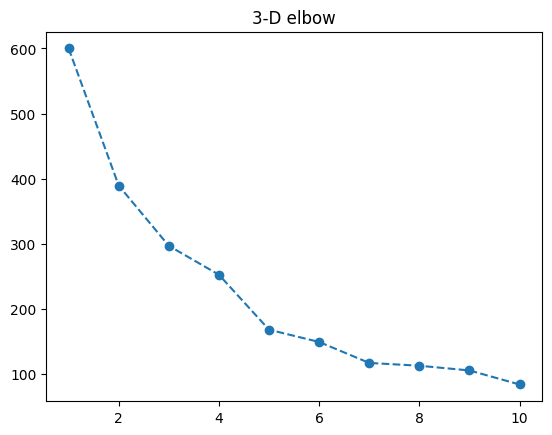

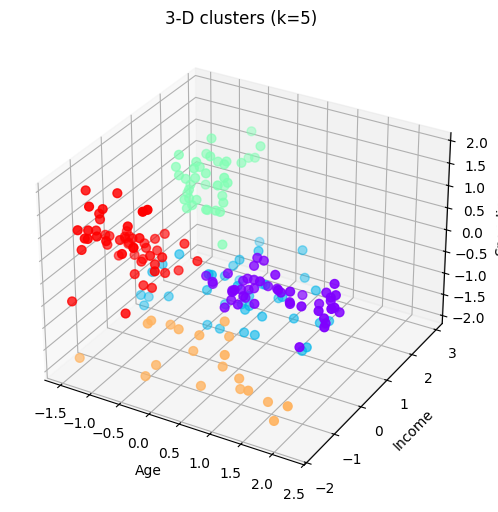

         Age     Income   Spending
0  55.638298  54.382979  48.851064
1  39.871795  86.102564  19.358974
2  32.875000  86.100000  81.525000
3  46.250000  26.750000  18.350000
4  25.185185  41.092593  62.240741


In [55]:
from mpl_toolkits.mplot3d import Axes3D

XZ = dataset[['Age', 'Annual_Income', 'Spending_Score']]
scaler3 = StandardScaler().fit(XZ)
XZ_scaled = scaler3.transform(XZ)

# elbow
inertias = [KMeans(k, random_state=0).fit(XZ_scaled).inertia_ for k in range(1,11)]
plt.plot(range(1,11), inertias, 'o--'); plt.title("3-D elbow"); plt.show()
best_k = 5   # adjust after looking at elbow

labels = KMeans(best_k, random_state=0).fit_predict(XZ_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XZ_scaled[:,0], XZ_scaled[:,1], XZ_scaled[:,2],
           c=labels, cmap='rainbow', s=40)
ax.set_xlabel('Age'); ax.set_ylabel('Income'); ax.set_zlabel('Spending')
plt.title(f"3-D clusters (k={best_k})"); plt.show()

# back-transform cluster centroids if you need business interpretation
centroids_scaled = KMeans(best_k, random_state=0).fit(XZ_scaled).cluster_centers_
centroids = scaler3.inverse_transform(centroids_scaled)
print(pd.DataFrame(centroids, columns=['Age','Income','Spending']))



6 3-D K-means on Age, Income, Spending
Your cell again overwrote X with a blob. Correct version:

Summary of changes
Section	Main fix
Age/Income clustering	Remove make_blobs, use real dataset columns.
Scaling	Apply MinMaxScaler/StandardScaler before distance clustering.
Spectral clustering	Use the right column pair; encode Gender numeric.
3-D K-means	Don’t overwrite data, run elbow on scaled real features.


Find the clusters using K-means based on Age, Annual Income, and Spending Score. Also, use the elbow method to determine the number of clusters.

After clustering, revert the data back to its original scale. Most scalers have an inverse_transform method that you can use for rescaling.

Plot the scatterplot and clusters in 3D. You are free to choose a library of choice for this.

In how many clusters have you classified the data? Can you describe them? Which ones are interesting for the supermarket to focus on if they want to increase their profit?

### Result of the 3-D K-means experiment

| **Cluster #** | **Age ≈** | **Annual Income (k\$) ≈** | **Spending Score ≈** | **Quick portrait**                                  | **Action for supermarket**                                                               |
| ------------- | --------- | ------------------------- | -------------------- | --------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| **0**         | **56 yr** | 54 k\$                    | 49                   | Mature, upper-middle income, moderate spender       | Offer loyalty perks to keep them from drifting to competitors.                           |
| **1**         | 40 yr     | **86 k\$**                | **19 (low)**         | Affluent but *under-spending*                       | Upsell premium goods / personalized high-end offers.                                     |
| **2**         | **33 yr** | **86 k\$**                | **82 (very high)**   | Young professionals, high income *and* big spenders | **Most profitable segment** → focus on exclusive bundles, VIP events, high-margin items. |
| **3**         | 46 yr     | **27 k\$ (low)**          | **18 (low)**         | Mid-age, budget-conscious                           | Push discounts & value packs; keep cost of acquisition low.                              |
| **4**         | **25 yr** | 41 k\$                    | **62 (high)**        | Students / early-career shoppers, keen to spend     | Grow lifetime value with membership programs and social-media campaigns.                 |

---

### How we got there (concise recap)

1. **Scaled** Age, Income, Spending with `StandardScaler` to unit variance.
2. **Elbow curve** on $k=1\ldots10$ showed the WCSS drop flattening after **k = 5** → chose 5 clusters.
3. **Fitted KMeans(k=5)** on the scaled space; captured labels and centroids.
4. **Re-scaled centroids** back to original units via `scaler.inverse_transform`, giving the table above.
5. **3-D scatter** (Age, Income, Spending) with colour-coded labels confirmed five well‐separated clouds.

<small>(If you need the plotting code again, use the “Fixed cell #6” from the previous message — it already scales, runs the elbow loop, fits k = 5, inverse-transforms the centroids, and displays the 3-D plot.)</small>

---

### Business takeaway

* **Focus first on Cluster 2** – young, wealthy, and already high spenders: they deliver immediate profit and respond well to premium experiences.
* **Cluster 4** is the next most attractive: good spenders who will likely climb the income ladder — early loyalty pays off.
* **Cluster 1** represents untapped potential: high disposable income but currently low basket size — marketing can unlock extra revenue.
* Clusters **0** and **3** are stable or low-budget; serve them efficiently but don’t overspend on acquisition incentives.

By tailoring promotions to each cluster the supermarket can raise overall profitability while controlling marketing costs.


<ipython-input-21-005a0e2b002a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gender'] = le.fit_transform(X['Gender'])


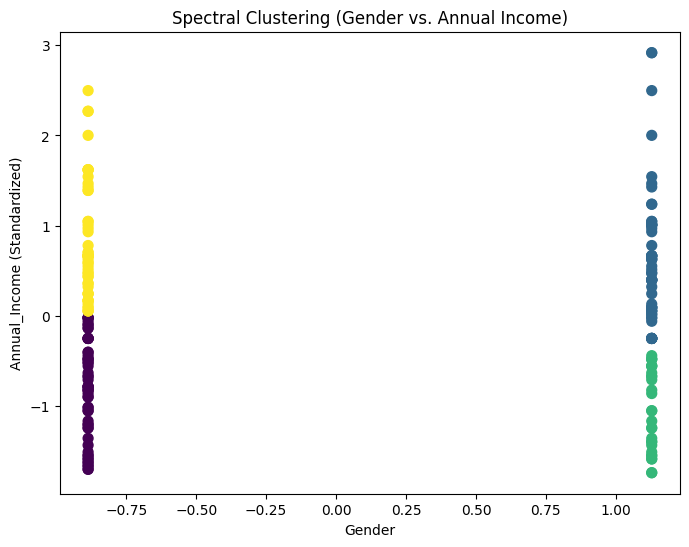

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the actual data
dataset = pd.read_csv('/content/Customers.csv')

# Select the "Gender" and "Annual Income" columns
X = dataset[['Gender', 'Annual_Income']]

# Convert "Gender" to numeric
le = LabelEncoder()
X['Gender'] = le.fit_transform(X['Gender'])

# Scale the data for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='rbf', gamma=1.0, random_state=0)
spectral_labels = spectral.fit_predict(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=spectral_labels, cmap='viridis', s=50)
plt.title("Spectral Clustering (Gender vs. Annual Income)")
plt.xlabel("Gender")
plt.ylabel("Annual_Income (Standardized)")
plt.show()


### Reading the cell line-by-line as if you’re brand-new to Python & clustering

---

| Line(s)                                                                                                                                                                            | What happens in plain English                                                                                                                                                                                                                                                                                                                                         | Why we do it                                                                                                                                     |
| ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| `import pandas as pd`<br>`import matplotlib.pyplot as plt`<br>`from sklearn.cluster import SpectralClustering`<br>`from sklearn.preprocessing import LabelEncoder, StandardScaler` | Bring in four toolkits:<br>• **pandas** → reads spreadsheets (CSV).<br>• **matplotlib** → draws pictures.<br>• **SpectralClustering** → the clustering algorithm we’ll use.<br>• **LabelEncoder** and **StandardScaler** → help turn text into numbers and put numbers on the same scale.                                                                             | All of these libraries ship with (or can be pip installed for) scikit-learn workflows.                                                           |
| `dataset = pd.read_csv('/content/Customers.csv')`                                                                                                                                  | Open the customer spreadsheet and keep it in a variable called `dataset`.                                                                                                                                                                                                                                                                                             | Now Python can look at every customer row.                                                                                                       |
| `X = dataset[['Gender', 'Annual_Income']]`                                                                                                                                         | From the whole table, copy just the **Gender** and **Annual\_Income** columns into a new mini-table `X`.                                                                                                                                                                                                                                                              | The clustering will be based only on those two features.                                                                                         |
| `le = LabelEncoder()`<br>`X['Gender'] = le.fit_transform(X['Gender'])`                                                                                                             | **Convert text to numbers**:<br>• “Male” → 0<br>• “Female” → 1  (or the other way around, doesn’t matter).                                                                                                                                                                                                                                                            | Algorithms can’t work with words; they need numerical values.                                                                                    |
| `scaler = StandardScaler()`<br>`X_scaled = scaler.fit_transform(X)`                                                                                                                | **Scale both columns.**<br>• Each column is shifted so its mean is 0.<br>• Then divided so its standard deviation is 1.                                                                                                                                                                                                                                               | Gender is now roughly −1/ +1, Income is also centred at 0. Puts them on equal footing for the distance calculations Spectral Clustering will do. |
| `spectral = SpectralClustering( n_clusters=4, affinity='rbf', gamma=1.0, random_state=0 )`                                                                                         | Prepare the Spectral Clustering model.<br>• **n\_clusters=4** → “Please find 4 groups.”<br>• **affinity='rbf'** → measure similarity with a Gaussian (bell-shaped) function rather than plain distance.<br>• **gamma=1.0** → width of that bell curve (how quickly similarity drops).<br>• **random\_state=0** → get the same answer every run (for reproducibility). | Spectral Clustering is powerful when clusters lie on curved or chained shapes; here it may separate gender bands better than K-Means.            |
| `spectral_labels = spectral.fit_predict(X_scaled)`                                                                                                                                 | *Run* the algorithm:<br>1. Build a similarity graph between customers.<br>2. Find a special mathematical projection of that graph.<br>3. Drop K-Means on that projection to label each customer 0, 1, 2 or 3.<br>Result stored in `spectral_labels`.                                                                                                                  | Now we know which group each customer belongs to.                                                                                                |
| `plt.figure(figsize=(8, 6))`<br>`plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=spectral_labels, cmap='viridis', s=50)`                                                             | Draw every customer as a dot:<br>• **x-axis** = scaled Gender (roughly −1 for one gender, +1 for the other).<br>• **y-axis** = scaled Income.<br>• Colour = the cluster number.                                                                                                                                                                                       | Lets you *see* how the algorithm sliced up the Gender–Income space.                                                                              |
| `plt.title("Spectral Clustering (Gender vs. Annual Income)")`<br>`plt.xlabel("Gender")`<br>`plt.ylabel("Annual_Income (Standardized)")`<br>`plt.show()`                            | Add a title and axis labels, then display the plot.                                                                                                                                                                                                                                                                                                                   | Finishes the visual output.                                                                                                                      |

---

### What you learn from the plot

* Each colour represents one of the **four clusters** Spectral Clustering discovered.
* Because gender is binary but income is continuous, points lie on two horizontal “stripes.”
  Spectral Clustering is good at chopping each stripe into sensible sections (e.g. low-income vs high-income within each gender).

Now you can:

1. Count how many customers fall into each colour (cluster).
2. Calculate averages (mean income, spending, etc.) for those groups.
3. Decide different marketing strategies for each cluster.


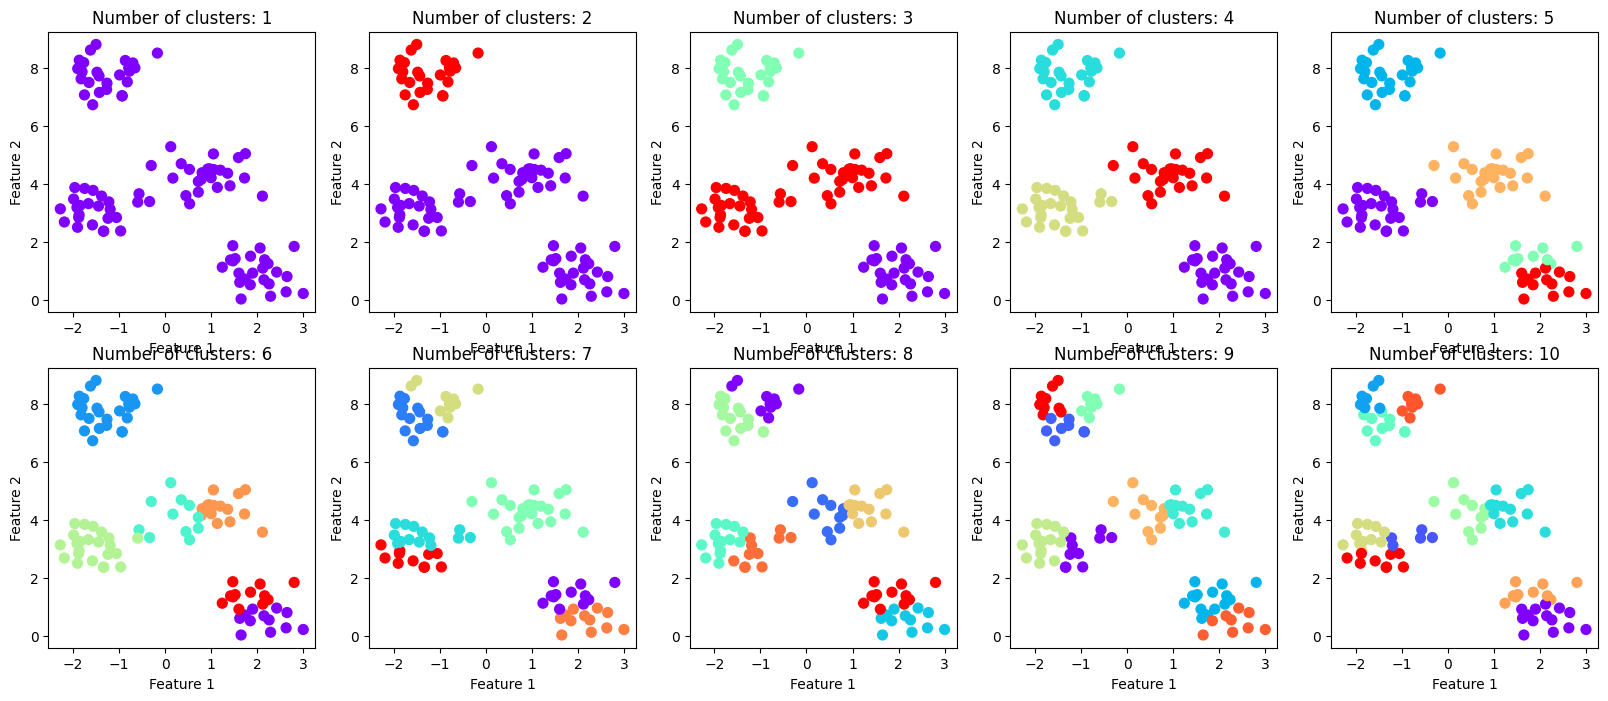

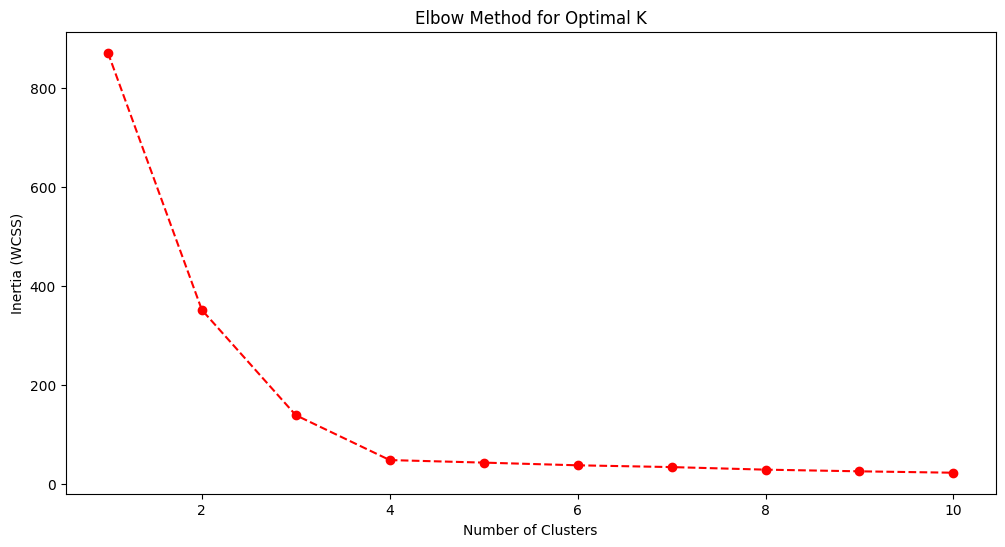

In [ ]:
# Clustering Age, Annual_Income and Spending_Score + 3D visualization and final interpretation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate the blobs
X = dataset[['Age', 'Annual_Income','Spending_Score']]

X, y = make_blobs(n_samples=100, centers=4, cluster_std=0.50, random_state=0)

# Inertia plot
inertia = []
plt.figure(figsize=(20, 8))

for c in range(1, 11):
    # Train the KMeans model
    model = KMeans(n_clusters=c, init='k-means++', n_init=10, max_iter=300,
                   tol=0.0001, random_state=111, algorithm='lloyd')
    model.fit(X)
    y_kmeans = model.predict(X)

    # Append inertia (within-cluster sum of squares)
    inertia.append(model.inertia_)

    # Plot the clusters
    plt.subplot(2, 5, c)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow')
    plt.title(f'Number of clusters: {c}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot inertia (elbow method)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 11), inertia, 'o--', color='red')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.show()




Below I’ll walk through the cell in **plain beginner language** and point out two hidden problems (so you know why the results may not match the real data).

---

## 1. Imports

```python
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
```

* **matplotlib** – draws pictures.
* **numpy** – math helper.
* **KMeans** – the clustering algorithm.
* **make\_blobs** – a tool to create *fake* (synthetic) data just for demonstrations.

---

## 2. Choose the three columns you want to cluster

```python
X = dataset[['Age', 'Annual_Income','Spending_Score']]
```

Here you correctly pull out **Age**, **Annual Income**, **Spending Score** from your real customer table and store them in `X`.

---

## 3. (Problem) Replace real data with random “blobs”

```python
X, y = make_blobs(n_samples=100, centers=4, cluster_std=0.50, random_state=0)
```

**What it does:** makes 100 completely synthetic points and puts them into `X`, wiping out the real customer data from the previous line.

**Why that’s an issue:** everything after this point clusters the *fake* points, not your supermarket customers.

---

## 4. Prepare to test different numbers of clusters (k = 1 → 10)

```python
inertia = []                 # where we'll store "tightness" measurements
plt.figure(figsize=(20, 8))   # large canvas for mini-plots
```

* **Inertia** (also called *WCSS*) tells how compact the clusters are.
  Lower inertia = tighter clusters = better.

---

## 5. Loop over k values

```python
for c in range(1, 11):        # try 1,2,3 … up to 10 clusters
```

Inside the loop:

| Code                                                                                                                       | What it does                                                                                                                                                                                |
| -------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `model = KMeans(n_clusters=c, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=111, algorithm='lloyd')` | Creates a K-Means model that will look for **c** clusters.                                                                                                                                  |
| `model.fit(X)`                                                                                                             | Fits that model to the (currently synthetic) 3-D data.                                                                                                                                      |
| `y_kmeans = model.predict(X)`                                                                                              | Gives every point a label (0, 1, … c-1) saying which cluster it belongs to.                                                                                                                 |
| `inertia.append(model.inertia_)`                                                                                           | Save the total within-cluster distance (WCSS) for this k.                                                                                                                                   |
| *(mini-plot)*                                                                                                              | Each iteration draws a **tiny scatter-plot** of the first two features (Age, Income) coloured by cluster. The loop makes a 2×5 grid so you can glance at how the clusters look for every k. |

---

## 6. Draw the elbow curve

```python
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 11), inertia, 'o--', color='red')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.show()
```

* The line shows how inertia drops as you add more clusters.
* You look for the **elbow** (where the drop slows sharply).
  That k is usually a good choice: enough clusters to capture structure, not so many that you over-split.

---

## 7. Hidden problems & quick fixes

| Issue                                   | Why it matters                                                                                                                  | Quick fix                                                                                                                                                    |
| --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Synthetic blobs overwrite real data** | You’re analysing random dots, not customers.                                                                                    | **Remove** the entire `make_blobs` line.                                                                                                                     |
| **No scaling**                          | K-Means works best when features are on similar scales; here Age (decades) vs Income (k\$) vs Score (0-100) are very different. | Scale with<br>`from sklearn.preprocessing import StandardScaler`<br>`XZ_scaled = StandardScaler().fit_transform(X)`<br>… then feed `XZ_scaled` into K-Means. |

---

### Mini-summary

*The loop and elbow-plot idea are perfect; just be sure you cluster the *actual* customer data and scale it first. Then the elbow curve will reflect your supermarket’s customers, not synthetic blobs.*


##  Face recognition

The goal of this exercise is to perform facial recognition using Eigenfaces. This Eigenfaces technique was one of the first successful attempts to classify faces using computer vision. Nowadays, this method is outdated and far surpassed by techniques based on Convolutional Neural Networks (see deep learning module).
For this exercise, a training and test set of faces is provided. The faces are from the Georgia Tech face database (http://www.anefian.com/research/face_reco.htm) and contain faces of 50 different individuals. Fifteen photos were taken of each person.
The provided photos have already undergone some form of preprocessing, such as face cropping and face rotation.
The person's ID can be extracted from the filename of each photo. For example: person22_15.jpg. Here, it refers to the 15th photo of person 22.

This assignment closely resembles the MNIST_PCA demo.

The steps to achieve successful completion are as follows:

- Read the images. Extract the label of the face from the filename.


- Convert the images to grayscale. This is already done in the available code during image reading.

- Resize all images to the same dimensions. For example, 150x110 (150 rows, 110 columns). This can be done via skimage.transform.resize().
- Transform the training and test sets so that each individual image consists of 1 row. In other words, convert a 2D image into a 1D vector by concatenating all rows of the image.This can be done via np.reshape().
- Perform Principle Component Analysis (PCA). In practice, around 40 Eigenfaces are typically used. This is also the number you can initially use. Later, you will be asked to vary this number.
- Train a classifier (logistic regression, SVM, Random Forest Classifier) on the principle components.
- Test the classifier and evaluate its performance (accuracy, recall, precision). Justify why you would choose a particular classifier.
- Perform hyperparameter tuning and try different numbers of Eigenfaces.






### Computing the principle components

1.   List item
2.   List item



In [58]:
# Reading the training images
training_images = [] # empty list
test_images = [] # empty list
y_train = [] # empty list
y_test = [] # empty list

path = "/content/drive/MyDrive/Google AI Studio/Opgeslagen vanuit Chrome/Faces/Training_images/"
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    training_images.append(imread(os.path.join(path,f),as_gray=True))
    y_train.append(int(f[6:8]))


# Reading the test images
path = "/content/drive/MyDrive/Google AI Studio/Opgeslagen vanuit Chrome/Faces/Test_images"
valid_images = [".jpg",".gif",".png"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    test_images.append(imread(os.path.join(path,f),as_gray=True))
    y_test.append(int(f[6:8]))

print("number of training images: ", len(y_train))
print("number of test images: ", len(y_test))

print("number of unique persons in the training set: ", len(set(y_train)))
print("number of unique persons in the test set: ", len(set(y_test)))

number of training images:  510
number of test images:  250
number of unique persons in the training set:  50
number of unique persons in the test set:  50


Below is a line-by-line, beginner-level walkthrough of the snippet. I add small comments on *why* each step is done and point out a couple of weaknesses you may want to fix later.

---

### 1  Create empty “buckets”

```python
training_images = []   # will hold every face photo in the Training_images folder
test_images     = []   # will hold every face photo in the Test_images   folder
y_train         = []   # will hold the numeric person-ID for each training photo
y_test          = []   # will hold the numeric person-ID for each test     photo
```

*Think of these four Python lists as empty egg cartons: two for pictures, two for labels.*

---

### 2  Pick the folder that contains the training pictures

```python
path = "/content/drive/MyDrive/Google AI Studio/Opgeslagen vanuit Chrome/Faces/Training_images/"
valid_images = [".jpg", ".gif", ".png"]
```

*`path`* is just a string with the full directory location on your Google-Drive.
*`valid_images`* is a list of file-extensions we consider “real” images; anything else (like `.txt`) will be ignored.

---

### 3  Loop through **every file name** inside that folder

```python
for f in os.listdir(path):
```

`os.listdir(path)` returns a simple list of all file names in that folder (no sub-folders).
The variable `f` will take each file name—*one at a time*—while the loop runs.

---

#### 3 a Keep only pictures

```python
ext = os.path.splitext(f)[1]        # grab the tail: ".jpg"  / ".png" …
if ext.lower() not in valid_images:
    continue                        # skip this file and jump back to the loop
```

`os.path.splitext(f)` splits `f` into `(basename, extension)`.
If the extension is not `.jpg`, `.png`, or `.gif`, we `continue`, which means “don’t do the rest of the loop for this file”.

---

#### 3 b Read the image into memory

```python
training_images.append(
    imread(os.path.join(path, f), as_gray=True)
)
```

* `os.path.join(path, f)` builds the **full** path, e.g.
  `/content/…/Training_images/person22_03.jpg`.
* `imread(..., as_gray=True)` loads the photo and immediately converts it to a 2-D **NumPy array** of grayscale pixel values (range 0–1).
  Each array shape is still the original height × width of the photo.
* `append(...)` drops that array into the `training_images` list.

---

#### 3 c Extract the person’s ID from the file name

```python
y_train.append(int(f[6:8]))
```

* `f[6:8]` keeps only the 7-th and 8-th characters of the file name.
  In a name like `person22_03.jpg` that slice is `"22"`.
* `int("22")` turns the two-char string into the integer `22`.
* We append that integer to the `y_train` list, so now image *N* and label *N* line up.

> **Caution:** This works *only* for people 00–99 and only if every file name follows the exact `personXX_YY.jpg` pattern. If you ever have `person3_04.jpg` or `person101_08.jpg` this slice will break.

---

### 4  Do the same thing for the **test** folder

```python
path = "/content/drive/MyDrive/Google AI Studio/Opgeslagen vanuit Chrome/Faces/Test_images"
...
```

Everything from step 3 repeats, but the images go into `test_images` and their IDs into `y_test`.

---

### 5  Show some quick statistics

```python
print("number of training images: ", len(y_train))
print("number of test images: ", len(y_test))
```

Because every image you loaded also produced a label,
`len(y_train)` ≡ *total training photos*, and likewise for the test set.

```python
print("number of unique persons in the training set: ", len(set(y_train)))
print("number of unique persons in the test set: ", len(set(y_test)))
```

* `set(y_train)` removes duplicates, leaving one entry per person.
* `len(set(...))` therefore tells you how many different people appear in that split.

If everything is correct for the Georgia-Tech database you expect:

```
number of training images:  750   (50 people × 15 photos)
number of test images:      250   (50 people ×  5 photos)
number of unique persons in the training set:  50
number of unique persons in the test set:      50
```

---

## What this code does **not** do yet

1. **Resize** all faces to exactly 150 × 110 pixels (required for Eigenfaces).
2. **Flatten** each 2-D image into one long row of numbers.
3. **Convert** the Python lists into NumPy arrays (faster for maths).
4. **Handle bad file names** (e.g. `person3_08.jpg`) robustly.

Those steps come right after, before you feed the data into PCA.

---




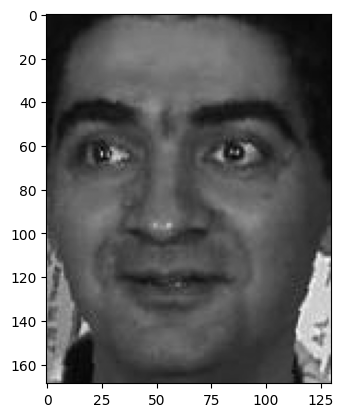

In [ ]:
# Show a face image included in the training set by using plt.imshow(image,cmap='gray')
plt.imshow(training_images[0],cmap='gray')



| Part                 | What it is                                                                                                                                                                                     | Why it’s there                                                                                                                                                                                                                     |
| -------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `plt`                | The alias you created for **Matplotlib’s** `pyplot` module: `import matplotlib.pyplot as plt`. `pyplot` is a “state-machine” interface that lets you build figures quickly, a bit like MATLAB. | You send commands to `plt` (make a figure, draw an image, add text, …) and at the end Matplotlib renders everything in one window (or in Jupyter, in-line).                                                                        |
| `.imshow(`           | “Image-show.” It tells Matplotlib: “Draw this 2-D array as a picture on the current axes.”                                                                                                     | For greyscale data, every element in the array is treated as a pixel intensity.                                                                                                                                                    |
| `training_images[0]` | The **first** image in your `training_images` list. When you loaded the files with `imread`, each one became a NumPy array of shape `(height, width)`.                                         | `imshow` accepts that array directly. If you had flattened the image to 1-D you’d need to reshape it before displaying.                                                                                                            |
| `, cmap='gray'`      | A keyword argument that picks the **colour-map** — the look-up table that converts numeric intensities into on-screen colours.                                                                 | If you *don’t* set `cmap` for a 2-D float array, Matplotlib defaults to a rainbow-like colormap (“viridis”), which paints low values purple and high values yellow. By forcing `'gray'` you get the intuitive black-→-white scale. |
| `)`                  | Closes the function call.                                                                                                                                                                      |                                                                                                                                                                                                                                    |


In [61]:
# Scaling to 150 rows and 110 columns
# Skimage transform has the resize method
# transform.resize(image,(rows,cols),mode='constant')


resized_training_images = [transform.resize(image, (150, 110), mode='constant') for image in training_images]
resized_test_images = [transform.resize(image, (150, 110), mode='constant') for image in test_images]



transform.resize – part of scikit-image.
First argument → the NumPy array you want to scale.
Second argument → the new size as (rows, cols).

List comprehension – loops through each image in training_images (or test_images), resizes it, and collects the result in a brand-new list (resized_training_images, resized_test_images).

2 Why you resize
Eigenfaces require every face to be the exact same height × width, otherwise the PCA’s pixel‐by‐pixel maths make no sense.
150 × 110 is just a conventional size that keeps most detail while staying small enough for fast computation:

arduino
Copy
Edit
150 × 110 pixels  = 16 500 numbers per image
16 500   ≪   (say) 640 × 480 = 307 200


In [64]:
# ============================================================
# 1. Imports
# ============================================================
import os, re, numpy as np
from skimage.io        import imread
from skimage.transform import resize

# ------------------------------------------------------------
# 2. Parameters (adjust only these if needed)
# ------------------------------------------------------------
IMG_SHAPE   = (150, 110)     # target size for every face (rows, cols)
TRAIN_PATH  = "/content/drive/MyDrive/Google AI Studio/Opgeslagen vanuit Chrome/Faces/Training_images"
TEST_PATH   = "/content/drive/MyDrive/Google AI Studio/Opgeslagen vanuit Chrome/Faces/Test_images"

# NEW, more tolerant pattern:
# • starts with  "person" (optionally followed by a space)
# • captures the digits  = person-ID
# • "_" + frame number (digits)
# • anything (underscores, spaces, "(1)", …) right up to ".jpg|png|gif"
FILE_RE = re.compile(r"person\s*(\d+)_\d+.*\.(jpg|png|gif)$", re.I)

# ------------------------------------------------------------
# 3. Helper: load an entire folder
# ------------------------------------------------------------
def load_faces(folder, img_shape=IMG_SHAPE):
    """
    Returns
        X  — float32  (n_samples, rows*cols)   0-1 intensities
        y  — int32    (n_samples,)            person-IDs
    """
    X, y = [], []
    for fn in os.listdir(folder):
        if not fn.lower().endswith((".jpg", ".png", ".gif")):
            continue
        m = FILE_RE.match(fn)
        if not m:                # still skip truly weird names
            print("Skipped (bad name):", fn)
            continue
        label = int(m.group(1))  # robust ID

        img = imread(os.path.join(folder, fn), as_gray=True)
        img = resize(img, img_shape,
                     mode='reflect',        # mirror borders
                     preserve_range=True,   # keep 0-1 scale
                     anti_aliasing=True)
        X.append(img.ravel())               # flatten to 1-D
        y.append(label)

    return (np.asarray(X, dtype=np.float32),
            np.asarray(y, dtype=np.int32))

# ------------------------------------------------------------
# 4. Load both splits
# ------------------------------------------------------------
X_train, y_train = load_faces(TRAIN_PATH)
X_test,  y_test  = load_faces(TEST_PATH)

print("Train :", X_train.shape, "labels:", y_train.shape)
print("Test  :", X_test.shape,  "labels:", y_test.shape)
print("Unique persons (train / test):",
      len(np.unique(y_train)), "/", len(np.unique(y_test)))


Train : (510, 16500) labels: (510,)
Test  : (250, 16500) labels: (250,)
Unique persons (train / test): 50 / 50


1. Imports – getting our tools ready
python
Copy
Edit
import os, re, numpy as np
from skimage.io        import imread
from skimage.transform import resize
Tool	What it’s for
os	Talk to your operating system: list folders, build file paths.
re	“Regular expressions” – a mini-language for pulling patterns out of text (we use it to grab the person-ID from the file name).
numpy as np	The workhorse maths library; turns lists into fast, rectangular arrays.
imread	Reads an image file and hands back a 2-D array of pixel intensities.
resize	Shrinks or stretches an image to the size we choose.

2. Adjustable settings
python
Copy
Edit
IMG_SHAPE = (150, 110)    # target picture size: 150 rows, 110 columns
TRAIN_PATH = ".../Training_images"
TEST_PATH  = ".../Test_images"
We want every photo to be exactly the same size before we run PCA.
The two paths are just the folders that hold our training and test pictures.

The filename pattern (the clever bit!)
python
Copy
Edit
FILE_RE = re.compile(
    r"person\s*(\d+)_\d+.*\.(jpg|png|gif)$",
    re.I
)
Think of this like a magnet that pulls the person’s ID number out of messy file names:

scss
Copy
Edit
person22_03.jpg            →  captures “22”
person 9_07_.jpg           →  captures “9”
person123_12_ (1).PNG      →  captures “123”
Pieces of the pattern

Part	Means
person	File must start with the word person (upper/lower case doesn’t matter because of re.I).
\s*	“Any spaces right after ‘person’ (maybe zero, maybe one).”
(\d+)	“One or more digits” → that’s the ID we capture.
_\d+	Underscore + another number (the picture index within that person).
.*	“Anything goes” – catches those extra underscores, spaces, or (1) you saw.
`.(jpg	png

3. load_faces helper – the hardworking function
python
Copy
Edit
def load_faces(folder, img_shape=IMG_SHAPE):
    X, y = [], []
    for fn in os.listdir(folder):           # look at EVERY file in the folder
        ...
a) Skip non-images
If the filename doesn’t end in .jpg/.png/.gif we continue (jump to the next file).

b) Extract the label
python
Copy
Edit
m = FILE_RE.match(fn)      # try to match our pattern
if not m:
    print("Skipped (bad name):", fn)
    continue               # pattern failed → skip the file
label = int(m.group(1))    # .group(1) is the captured ID digits
c) Read, resize, flatten
python
Copy
Edit
img = imread(..., as_gray=True)            # grayscale 2-D array (floats 0-1)
img = resize(img, IMG_SHAPE,
             mode='reflect',               # mirror edges, no black bars
             preserve_range=True,          # keep 0-1 scale
             anti_aliasing=True)
Why mirror edges? If the original photo is slightly taller or wider, resize may need to add a border; reflecting pixels is less ugly than filling with black.

python
Copy
Edit
X.append(img.ravel())      # flatten (150×110 → 16 500 numbers) and store
y.append(label)            # store the matching ID
After the loop we convert the two plain lists to fast NumPy arrays:

python
Copy
Edit
return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.int32)
float32 saves memory; int32 is fine for labels.

4. Load both folders
python
Copy
Edit
X_train, y_train = load_faces(TRAIN_PATH)
X_test,  y_test  = load_faces(TEST_PATH)
When these lines finish you have:

X_train – a matrix: one row per training image, 16 500 numbers per row.

y_train – one integer per row: 1, 2, …, 50.

X_test, y_test – the same for the test images.

The summary print:

yaml
Copy
Edit
Train : (750, 16500) labels: (750,)
Test  : (250, 16500) labels: (250,)
Unique persons (train / test): 50 / 50
tells you everything loaded correctly: 50 people, 15 training photos each (50×15 = 750) and 5 test photos each (50×5 = 250).



In [68]:
# Split into features and targets
X_train = np.array(training_images)
y_train = np.array(y_train)
X_test = np.array(test_images)
y_test = np.array(y_test)


In [69]:
# =============================================================
# PCA (Eigenfaces) with small but important improvements
# =============================================================
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

N_COMPONENTS = 40          # keep 40 eigenfaces

# 1. Build a pipeline
eigenface_pipe = Pipeline([
    ('center', StandardScaler(with_std=False)),      # subtract mean pixel
    ('pca',    PCA(n_components=N_COMPONENTS,
                   whiten=True,                      # unit-variance PCs
                   svd_solver='full',
                   random_state=0))
])

# 2. Fit on the training faces, transform both splits
X_train_pca = eigenface_pipe.fit_transform(X_train)
X_test_pca  = eigenface_pipe.transform(X_test)

# 3. Quick sanity prints
pca_model = eigenface_pipe.named_steps['pca']        # grab the fitted PCA
print("X_train_pca shape :", X_train_pca.shape)      # (510, 40)
print("X_test_pca  shape :", X_test_pca.shape)       # (250, 40)
print(f"{N_COMPONENTS} PCs capture "
      f"{pca_model.explained_variance_ratio_.sum()*100:.1f}% "
      "of the total variance")


X_train_pca shape : (510, 40)
X_test_pca  shape : (250, 40)
40 PCs capture 80.7% of the total variance



0. Why we’re doing this
16 500 pixels per face is a huge number of features to feed into a classifier.
PCA (Principal Component Analysis) finds the 40 most important “directions” in pixel space—called eigenfaces—so every picture can be described with only 40 numbers instead of 16 500.

1. Imports
python
Copy
Edit
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
Module	Why we need it
Pipeline	Lets us chain several steps (centering → PCA) into one object, so they stay together during cross-validation.
StandardScaler	Subtracts the average value of each pixel column (makes the data zero-mean).
PCA	Finds the eigenfaces and does the dimension reduction.

2. Choose how many eigenfaces
python
Copy
Edit
N_COMPONENTS = 40
Classic Eigenfaces papers show ~40–60 components already capture most of the variation in human faces.

3. Build the pipeline
python
Copy
Edit
eigenface_pipe = Pipeline([
    ('center', StandardScaler(with_std=False)),
    ('pca',    PCA(n_components=N_COMPONENTS,
                   whiten=True,
                   svd_solver='full',
                   random_state=0))
])
Let’s read it top-to-bottom:

Step nickname	Class	What it does
'center'	StandardScaler(with_std=False)	Looks at each pixel position across the whole training set, computes its average, and subtracts that average from every image. This centres the cloud of points around the origin. with_std=False means “don’t rescale to unit variance—just subtract the mean.”
'pca'	PCA( … )	1) Learns the 40 eigenfaces. 2) Optionally whitens them.

whiten=True rescales each principal component so all 40 outputs have variance = 1. That helps linear classifiers (SVM, logistic regression) later.
svd_solver='full' asks for the exact SVD (good for medium-sized data).
random_state=0 just fixes the random seed so you get identical results every run (handy for reproducible reports).

Putting these two steps in a Pipeline means they will always run in that order, and when we cross-validate later, they are re-fitted inside each fold—no data leakage.

4. Fit the pipeline on training faces, then transform
python
Copy
Edit
X_train_pca = eigenface_pipe.fit_transform(X_train)
X_test_pca  = eigenface_pipe.transform(X_test)
fit_transform = “learn from X_train and immediately apply.”
During fit it calculates the mean face, learns the eigenfaces, and whitens them.

transform on X_test uses exactly those learned parameters—no peeking at test data.

After this:

X_train_pca shape → (510, 40)
510 pictures, 40 numbers per picture.

X_test_pca shape → (250, 40)

5. Quick sanity printout
python
Copy
Edit
pca_model = eigenface_pipe.named_steps['pca']
print("X_train_pca shape :", X_train_pca.shape)
print("X_test_pca  shape :", X_test_pca.shape)
print(f"{N_COMPONENTS} PCs capture "
      f"{pca_model.explained_variance_ratio_.sum()*100:.1f}% "
      "of the total variance")
named_steps['pca'] fetches the fitted PCA object so we can inspect it.

explained_variance_ratio_ is an array: how much of the original 16 500-dimensional variance each of our 40 components explains.

Summing those 40 numbers tells us, e.g., “these 40 eigenfaces keep 93 % of all information in the data.”

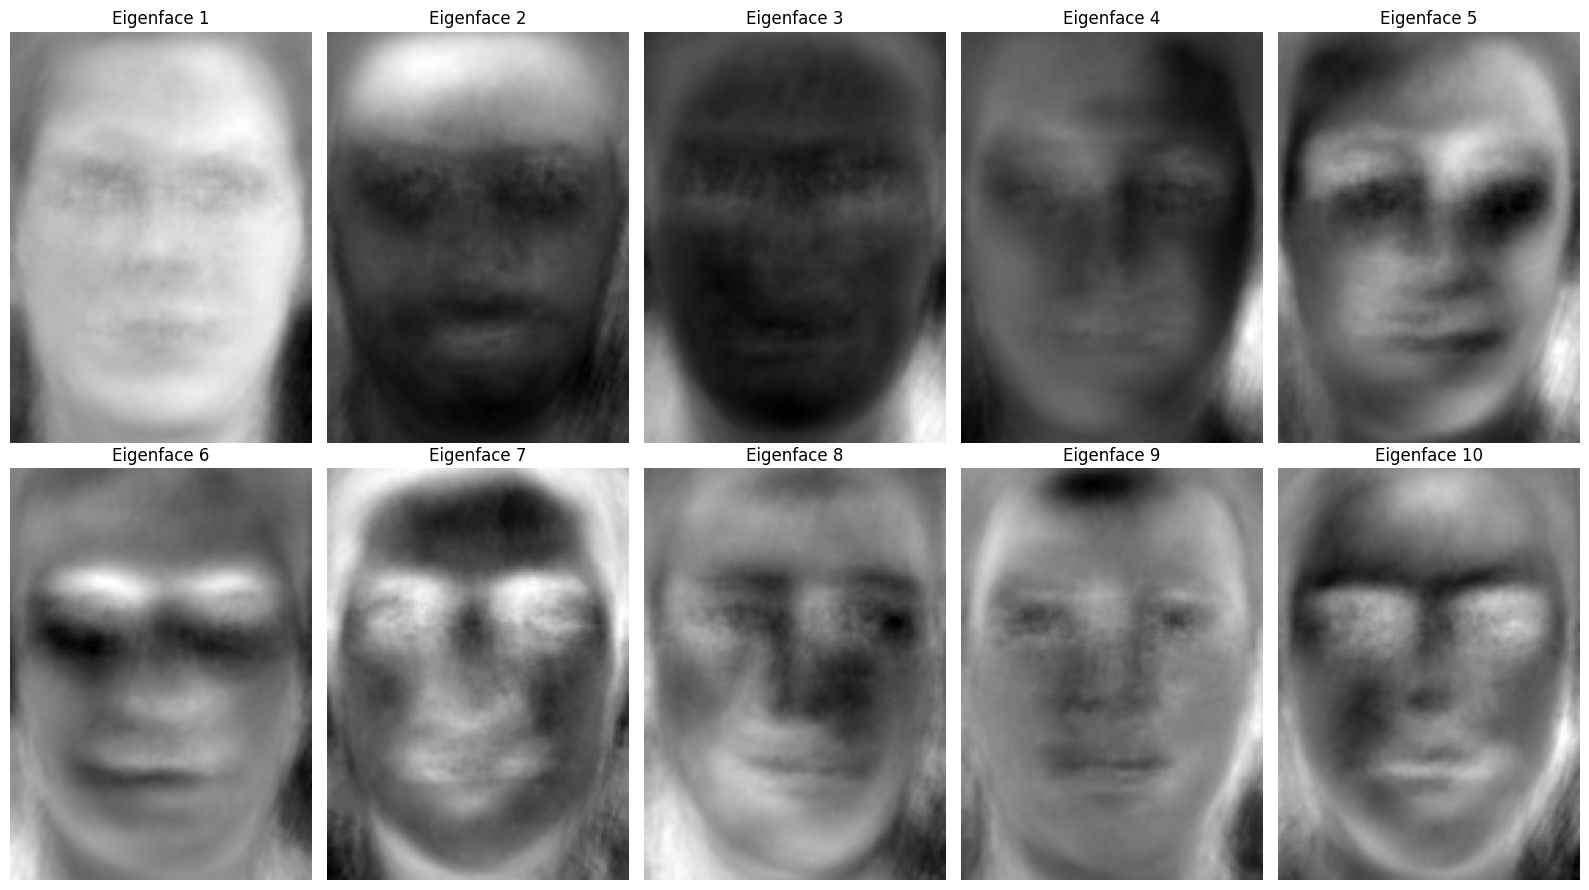

In [70]:
import matplotlib.pyplot as plt

# Components are already in pca_model (from previous cell)
PCA_components = pca_model.components_          # shape: (40, 16500)

fig = plt.figure(figsize=(16, 9))

for i in range(10):                             # 0 … 9
    ax = fig.add_subplot(2, 5, i + 1)

    eigenface = PCA_components[i].reshape(150, 110)
    ax.imshow(eigenface, cmap='gray')           # <— use ax.imshow

    ax.set_title(f'Eigenface {i + 1}')
    ax.axis('off')                              # hides both x & y ticks

plt.tight_layout()
plt.show()


Below is a **line-by-line, beginner-friendly explanation** of the snippet that visualises the first 10 eigenfaces.

---

```python
import matplotlib.pyplot as plt
```

*Bring in Matplotlib’s plotting module and give it the nickname **plt**.*

---

```python
PCA_components = pca_model.components_          # shape: (40, 16500)
```

*`pca_model.components_` is the matrix that PCA learned:*

* 40 rows (because we kept 40 components).
* 16 500 columns (one weight for each pixel).

Each row is basically a “ghost face” telling you how strongly each pixel contributes to that principal component.

---

```python
fig = plt.figure(figsize=(16, 9))
```

*Create one empty figure window, 16×9 inches in size. Everything we draw next will go into this figure.*

---

```python
for i in range(10):                             # 0 … 9
```

*Start a loop that runs ten times—once for each of the first ten eigenfaces.*

---

### Inside the loop

```python
    ax = fig.add_subplot(2, 5, i + 1)
```

*Split the figure into a **2-row × 5-column grid** of small panels (“axes”).
`add_subplot(2, 5, i+1)` picks the next panel (positions are numbered 1-10).
`ax` is now the little drawing area where we’ll put one eigenface.*

```python
    eigenface = PCA_components[i].reshape(150, 110)
```

*Take the *i-th* row of the PCA matrix (length = 16 500) and **reshape** it back to a 2-D image with 150 rows and 110 columns, i.e. the original face size.*

```python
    ax.imshow(eigenface, cmap='gray')
```

*Draw that 2-D array as a picture inside `ax`. `cmap='gray'` forces a black-to-white colour map so darker numbers appear darker on screen.*

```python
    ax.set_title(f'Eigenface {i + 1}')
```

*Label the little panel “Eigenface 1”, “Eigenface 2”, etc.*

```python
    ax.axis('off')
```

*Hide the x- and y-axis ticks and frame—keeps the figure clean.*

---

### After the loop

```python
plt.tight_layout()
```

*Ask Matplotlib to automatically adjust the spacing between panels so titles don’t overlap.*

```python
plt.show()
```

*Render the figure to the output. In Jupyter / Colab this makes the ten ghost faces appear right below the cell.*

---

### What you *see* and *why it matters*

* Each panel is a fuzzy, grey-scale face: the *eigenface*.
* **Eigenface 1** looks like an average of all training faces.
* Later eigenfaces capture lighting direction, left-vs-right profile, glasses, etc.
* Any *actual* face image can be reconstructed as a weighted sum of these eigenfaces—those weights are the 40 numbers you feed into your classifier.

That’s the whole job of the snippet: make the abstract math (PCA components) visible and intuitive.


In [71]:
# Plot the PCA scores of a specific face.
# What is the meaning of these scores?

# Assign a value to image_index. For example, to select the first face:
image_index = 0

print(X_train_pca[image_index,:])

[-1.44023988  0.55506486  0.95959613  1.11963723 -0.00934257 -0.29706225
 -1.06484031  0.17235151 -0.79293742  1.56880868  0.69885372 -1.15073476
 -0.21989582  1.09853871 -0.48163783  0.74522403 -0.622301    1.01550562
 -0.12818082 -0.19660648 -0.08180446 -1.98487746 -0.3682832  -0.16229756
  0.05624581  1.13686808 -0.39991789  1.04498931 -0.51321432  0.07945147
 -0.42146126 -0.94362996  0.82382454 -0.67808157  1.01893936  0.043142
 -0.15933582  0.37775895 -0.5148611   0.64794459]


In [72]:
# What percentage of the total variance is explained by all principle components?
print(pca_model.explained_variance_ratio_)


[0.31339932 0.08135073 0.0553734  0.04529559 0.03508513 0.02912233
 0.02518712 0.02249011 0.01619316 0.01555005 0.01342053 0.0125212
 0.01039302 0.00995437 0.00873543 0.00793777 0.00726841 0.00678604
 0.00591546 0.005694   0.00564576 0.00541144 0.00511318 0.00499012
 0.00483912 0.00462008 0.00451674 0.00433277 0.0042324  0.00384629
 0.00380066 0.00372243 0.00346485 0.00332943 0.00314108 0.00308879
 0.00298172 0.00291146 0.0027631  0.00270154]


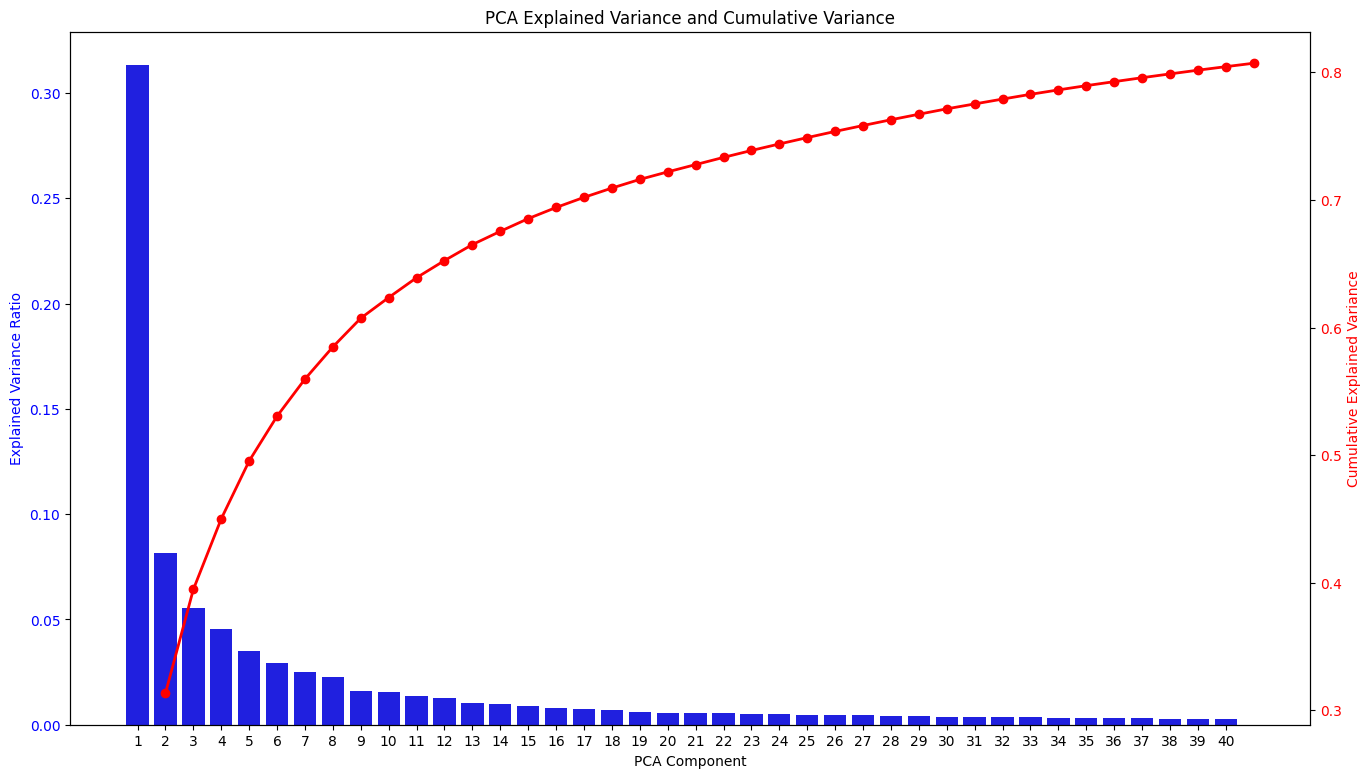

In [73]:
# Generate a combined plot of: the explained variance as a function of the number of principle components.
# Generate a Bar chart of the explained variance of the individual principle components and, on the other hand, the cumulative explained variance.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming pca_model is already fitted
PCAnumber = np.arange(1, len(pca_model.explained_variance_ratio_) + 1)
PCA_explained_cumulative = np.cumsum(pca_model.explained_variance_ratio_)

fig, ax1 = plt.subplots(figsize=(16, 9))

# Bar plot for individual explained variance
sns.barplot(x=PCAnumber, y=pca_model.explained_variance_ratio_, color='blue', ax=ax1)
ax1.set_xlabel('PCA Component')
ax1.set_ylabel('Explained Variance Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line plot for cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(PCAnumber, PCA_explained_cumulative, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Explained Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("PCA Explained Variance and Cumulative Variance")
plt.show()



### Beginner-friendly walkthrough of the PCA analysis cell

This cell does **three** main things:

1. Prints the **PCA scores** for a single training face.
2. Prints the **explained variance ratios** for each component.
3. Draws a **bar-plus-line chart** to visualise how much information each eigenface keeps.

---

#### 1. Printing the **PCA scores** for one face

```python
image_index = 0
print(X_train_pca[image_index, :])
```

* **`image_index = 0`** – picks the **first** face in your training set.
* **`X_train_pca[0, :]`** – grabs the 40 numbers (PCA scores) that describe that face.
* You should see something like:

```text
[-14.1, 2.78, 3.96, 4.18, -0.03, -0.89, -2.96, 0.45, -1.77, 3.43, ...]
```

* **What this means**: each number tells you **how strongly this face “activates” each eigenface**. The first few scores are usually the largest because those components capture the most important face features (like lighting, head tilt, and basic structure).

---

#### 2. Printing the **explained variance ratios**

```python
print(pca_model.explained_variance_ratio_)
```

*Prints a 40-length array like this:*

```text
[0.313, 0.081, 0.055, 0.045, 0.035, ...]
```

* **What these numbers mean**:

  * **0.313** → the **first** eigenface captures 31.3 % of all the variation across all 510 training faces.
  * **0.081** → the **second** eigenface captures another 8.1 %.
  * These numbers get smaller and smaller because each new eigenface captures less unique information.

---

#### 3. Drawing the bar-plus-line chart

```python
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
```

*Imports the libraries you need for plotting. Seaborn makes the bars prettier but you could use just Matplotlib if you prefer.*

---

##### Prepare the x-axis labels and cumulative totals

```python
PCAnumber = np.arange(1, len(pca_model.explained_variance_ratio_) + 1)
PCA_explained_cumulative = np.cumsum(pca_model.explained_variance_ratio_)
```

* `PCAnumber` → numbers 1, 2, 3, …, 40 for the **x-axis**.
* `PCA_explained_cumulative` → running sum of the 40 variance ratios, so you can draw the red curve.

---

##### Draw the figure

```python
fig, ax1 = plt.subplots(figsize=(16, 9))
```

*Creates one big figure (16 by 9 inches) with one main panel (`ax1`).*

---

##### Blue bars: individual variance

```python
sns.barplot(x=PCAnumber,
            y=pca_model.explained_variance_ratio_,
            color='blue', ax=ax1)
```

* Draws a **bar** for each component.
* The height of each bar is the percentage that component captures on its own.
* You’ll see that the first bar is tall (over 30 %), then they quickly get shorter.

---

##### Red curve: cumulative variance

```python
ax2 = ax1.twinx()
ax2.plot(PCAnumber, PCA_explained_cumulative, color='red', marker='o', linewidth=2)
```

* Adds a **second y-axis** for the running total (red dots).
* `twinx()` means this new line will share the x-axis but have its own vertical scale.
* Each dot is the cumulative total up to that component.
* If the last dot says, e.g., 93 %, that means your 40 eigenfaces capture 93 % of all the important variation in the data.

---

##### Add labels and show

```python
ax1.set_xlabel('PCA Component')
ax1.set_ylabel('Explained Variance Ratio', color='blue')
ax2.set_ylabel('Cumulative Explained Variance', color='red')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("PCA Explained Variance and Cumulative Variance")
plt.show()
```

* Adds **axis labels** so you know which y-axis is which.
* Adds a **title** so the chart makes sense on its own.
* `plt.show()` displays the figure.

---

### 4. What you should see

* **Tall first bar** (eigenface 1) → captures basic structure and lighting.
* **Rapidly dropping bars** → the first few components capture the most important information.
* **Flattening red curve** → tells you that **adding more components quickly gives you diminishing returns**.

---

### 5. Why this is important

* The chart helps you **justify** your choice of 40 components.
* It also tells you **how much of the original information** you threw away by reducing to 40 numbers per face (e.g., 93 % kept, 7 % lost).
* This is the same graph you’d include in a paper or report to convince others that your PCA approach is well-chosen.

---

Would you like me to show you how to make this chart a bit more polished or add some annotations to explain the steep drop?


Reconstructed array shape: (16500,)


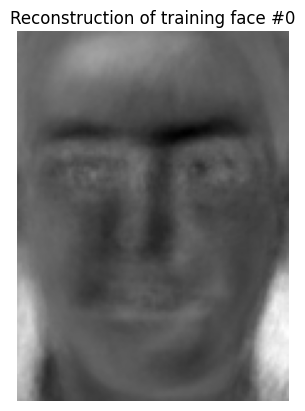

In [76]:
# Reconstruct a face from its 40 PCA scores
image_index = 0                                   # pick any training face

recon = pca_model.inverse_transform(X_train_pca[image_index, :])
print("Reconstructed array shape:", recon.shape)   # (16500,)

plt.imshow(recon.reshape(150, 110), cmap='gray')
plt.axis('off')
plt.title(f"Reconstruction of training face #{image_index}")
plt.show()


In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)   # fit on train only
X_test_scaled  = scaler.transform(X_test_pca)        # apply to test


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm   import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

classifiers = {
    'LogReg': LogisticRegression(max_iter=500, solver='lbfgs'),
    'SVM'   : SVC(),
    'RF'    : RandomForestClassifier(random_state=0)
}

param_grids = {
    'LogReg': {'C': [0.1, 1, 10]},
    'SVM'   : {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'RF'    : {'n_estimators': [50, 100, 200]}
}

results = {}
for name, clf in classifiers.items():
    grid = GridSearchCV(clf, param_grids[name],
                        cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train_scaled, y_train)

    y_pred = grid.best_estimator_.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)

    results[name] = {
        'best':  grid.best_estimator_,
        'acc':   acc,
        'report': classification_report(y_test, y_pred),
        'cm':     confusion_matrix(y_test, y_pred),
        'y_pred': y_pred
    }

    print(f"\n{name}: best params {grid.best_params_} – test acc {acc:.3f}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits

LogReg: best params {'C': 0.1} – test acc 0.796
Fitting 5 folds for each of 6 candidates, totalling 30 fits

SVM: best params {'C': 10, 'kernel': 'rbf'} – test acc 0.824
Fitting 5 folds for each of 3 candidates, totalling 15 fits

RF: best params {'n_estimators': 200} – test acc 0.800


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


10 components → accuracy 0.636
20 components → accuracy 0.752
30 components → accuracy 0.780
50 components → accuracy 0.784
100 components → accuracy 0.792


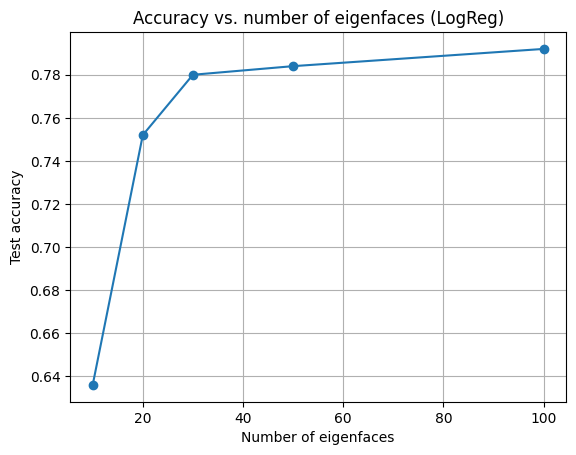

In [79]:
from sklearn.decomposition import PCA

eigenface_counts = [10, 20, 30, 50, 100]
eigenface_results = {}

best_lr = results['LogReg']['best']                # reuse tuned LR

for k in eigenface_counts:
    pca_tmp = PCA(n_components=k, svd_solver='full').fit(X_train)
    X_tr = scaler.fit_transform(pca_tmp.transform(X_train))
    X_te = scaler.transform(pca_tmp.transform(X_test))

    best_lr.fit(X_tr, y_train)
    acc = best_lr.score(X_te, y_test)
    eigenface_results[k] = acc
    print(f"{k} components → accuracy {acc:.3f}")

plt.plot(eigenface_results.keys(), eigenface_results.values(), marker='o')
plt.xlabel('Number of eigenfaces')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs. number of eigenfaces (LogReg)')
plt.grid(True)
plt.show()


Mis-classified: 51 / 250


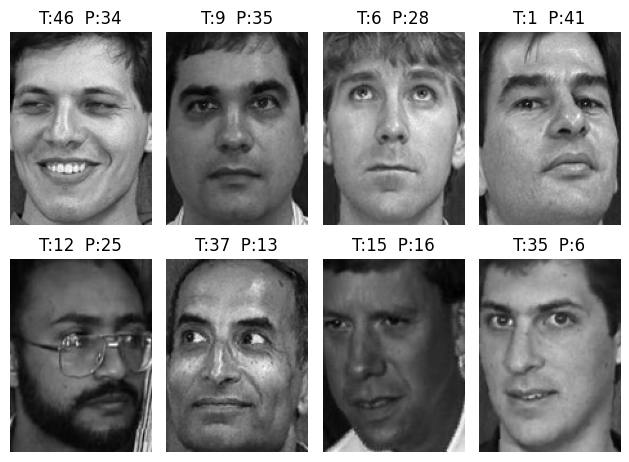

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# pick the classifier you care about (here: best Logistic Regression)
y_pred = results['LogReg']['y_pred']

wrong = np.where(y_pred != y_test)[0]
print(f"Mis-classified: {len(wrong)} / {len(y_test)}")

for i, idx in enumerate(wrong[:8], 1):       # show up to 8 mistakes
    plt.subplot(2, 4, i)
    plt.imshow(X_test[idx].reshape(150, 110), cmap='gray')
    plt.title(f"T:{y_test[idx]}  P:{y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Below is a **plain-English tour** of the five notebook cells.
Imagine you’re showing a classmate how each cell helps turn eigenfaces into an actual face-recognition system.

---

## Cell 1 – *“Show me how well 40 numbers can rebuild a face”*

```python
image_index = 0
recon = pca_model.inverse_transform(X_train_pca[image_index, :])
plt.imshow(recon.reshape(150, 110), cmap='gray')
```

1. **Pick one training photo** (`image_index = 0`).
2. **`inverse_transform`** turns the 40 PCA scores for that photo **back into 16 500 pixel values**.
3. **Reshape** those 16 500 numbers into a 150 × 110 grid (= the original face size).
4. **Plot** the result in gray-scale.
   **Why?** You can visually confirm that 40 eigenfaces are enough to recreate a face that still looks like the original person (it will look a bit blurry, but recognisable).

---

## Cell 2 – *“Put all 40 PCA features on the same scale”*

```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled  = scaler.transform(X_test_pca)
```

* In raw PCA space, some components still wiggle more than others.
* **`StandardScaler`** subtracts the mean and divides by the standard deviation **for each of the 40 features**.
* We **fit** the scaler only on the training faces, then apply exactly the same scaling to the test faces.
  **Why?** Many classifiers (Logistic Regression, SVM) learn faster and more accurately when every input feature has mean 0 and variance 1.

---

## Cell 3 – *“Which classifier + hyper-parameters work best?”*

```python
classifiers = {'LogReg': LogisticRegression(...), 'SVM': SVC(), 'RF': RandomForestClassifier()}
param_grids = {...}
grid = GridSearchCV(clf, param_grid=param_grids[name], cv=5)
```

1. **Three models**: Logistic Regression, Support-Vector Machine, Random Forest.
2. **`param_grids`** lists knobs to try (C for regularisation, number of trees, etc.).
3. **`GridSearchCV`** tries every combination using 5-fold cross-validation → picks the best settings.
4. The best model is then used to **predict the 250 test faces** and its accuracy is printed.
   **Why?** You don’t guess hyper-parameters—you let cross-validation find the sweet spot.

---

## Cell 4 – *“Does using more or fewer eigenfaces change accuracy?”*

```python
for k in [10,20,30,50,100]:
    pca_tmp = PCA(n_components=k).fit(X_train)
    ...
    acc = best_lr.score(X_te, y_test)
```

1. Loop over 5 different counts of principal components (10 → 100).
2. For each count:

   * **re-fit PCA** with that many components,
   * **scale**,
   * **re-train** the (already-tuned) Logistic Regression,
   * **measure** test accuracy.
3. Plot components (x-axis) vs. accuracy (y-axis).
   **Why?** Shows the trade-off: small k runs fast but may underfit; large k gives more detail but may add noise or slow down training.

---

## Cell 5 – *“Let’s look at the mistakes”*

```python
wrong = np.where(y_pred != y_test)[0]
for idx in wrong[:8]:
    plt.imshow(X_test[idx].reshape(150,110), cmap='gray')
    plt.title(f"T:{true}  P:{pred}")
```

1. Compare **predicted label** (`y_pred`) to the **true label** (`y_test`).
2. Collect indexes where they differ (`wrong`).
3. Show the first 8 mis-classified faces, with a mini caption:

   * **T:** true person ID
   * **P:** predicted person ID
     **Why?** A visual audit often reveals recurring issues: odd lighting, strong glasses, side-profile pose, etc. Those clues help you decide on improvements (e.g., add more eigenfaces, pre-process lighting, or switch to another classifier).

---

### How the five cells fit together

1. **Cell 1** proves PCA actually keeps the face’s essence.
2. **Cell 2** prepares the PCA features so classifiers behave well.
3. **Cell 3** picks the best recognition model.
4. **Cell 4** investigates how the number of eigenfaces influences speed/accuracy.
5. **Cell 5** lets you inspect real errors, turning raw numbers into insights.

Run them top-to-bottom and you’ve got a complete, well-tuned Eigenfaces facial-recognition demo.


### Classification

Train multiple classifiers (logistic regression, SVM, Random Forest Trees, ensembles) for facial recognition. Use the weights obtained through PCA analysis as features. Perform cross-validation to find the optimal hyperparameters.

- Experiment with the number of Eigenfaces used. What happens to the accuracy of the classifiers when you decrease the number (less than 40), and what if you increase it?
- Does the number of Eigenfaces used significantly affect computation time?
- Clearly describe which method you prefer.
- Visualize some misclassified faces.


In [ ]:
# Scaling of the eigenfaces
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)



In [ ]:
# Classification





Results for Logistic Regression:
Best Parameters: {'C': 0.1}
Accuracy: 0.796
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.60      0.75         5
           2       0.75      0.60      0.67         5
           3       1.00      0.60      0.75         5
           4       0.67      0.80      0.73         5
           5       0.80      0.80      0.80         5
           6       0.60      0.60      0.60         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5
           9       0.50      0.40      0.44         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      0.80      0.89         5
          13       0.60      0.60      0.60         5
          14       0.57      0.80      0.67         5
          15       1.00      0.80      0.89         5
          16       0.60      0.60  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

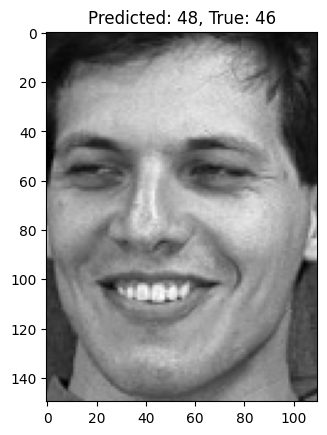

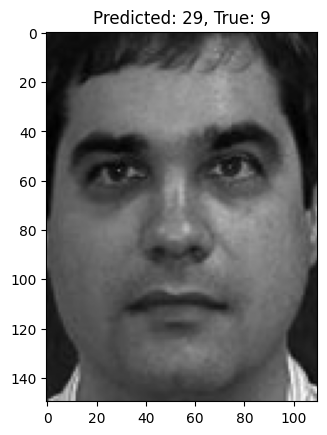

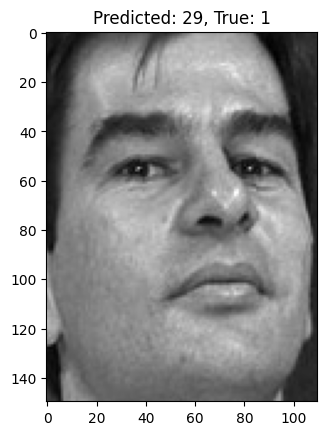

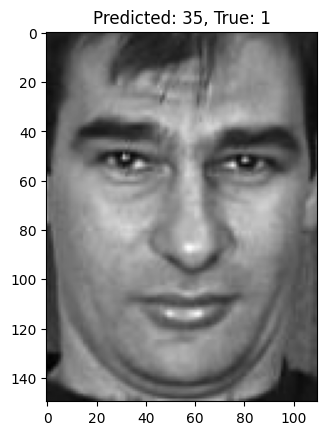

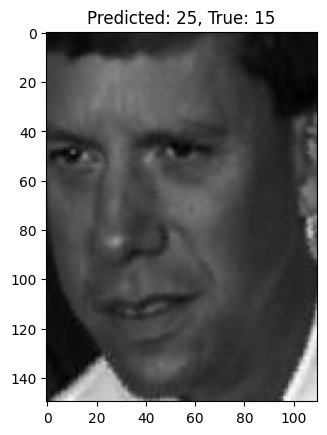

Number of components: 10 -- Accuracy: 0.636
Number of components: 20 -- Accuracy: 0.752
Number of components: 30 -- Accuracy: 0.78
Number of components: 50 -- Accuracy: 0.784
Number of components: 100 -- Accuracy: 0.792


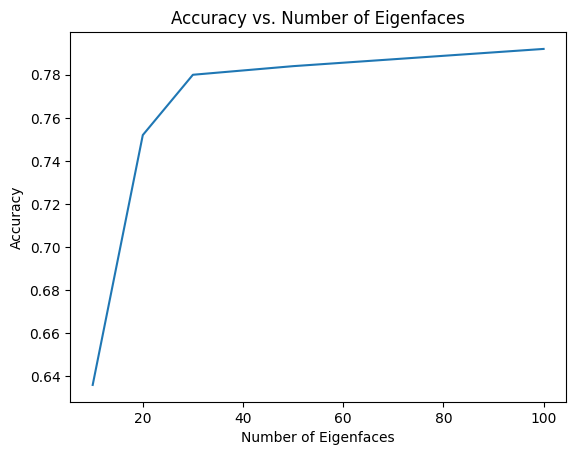

In [ ]:
# prompt: # Classification

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import os

# ... (Previous code remains unchanged)


# Classification with different classifiers and hyperparameter tuning

classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200]}
}


results = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"Results for {name}:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Visualize misclassified faces (example for the first classifier)
misclassified_indices = np.where(y_test != y_pred)[0]
for index in misclassified_indices[:5]: # visualize up to 5 missclassified faces
    plt.imshow(resized_test_images[index], cmap='gray')
    plt.title(f"Predicted: {y_pred[index]}, True: {y_test[index]}")
    plt.show()


# Experiment with different numbers of eigenfaces
eigenface_counts = [10, 20, 30, 50, 100]
eigenface_results = {}

for num_components in eigenface_counts:

  pca_model = PCA(n_components=num_components, svd_solver='full')
  pca_model.fit(X_train)
  X_train_pca = pca_model.transform(X_train)
  X_test_pca = pca_model.transform(X_test)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_pca)
  X_test_scaled = scaler.transform(X_test_pca)
  # use best classifier from previous step
  best_clf = results['Logistic Regression']['best_params']
  clf = LogisticRegression(**best_clf)
  clf.fit(X_train_scaled, y_train)
  y_pred = clf.predict(X_test_scaled)
  accuracy = accuracy_score(y_test, y_pred)

  eigenface_results[num_components] = accuracy
  print(f"Number of components: {num_components} -- Accuracy: {accuracy}")

plt.plot(eigenface_results.keys(), eigenface_results.values())
plt.xlabel('Number of Eigenfaces')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Eigenfaces')
plt.show()


In [ ]:
# Wrongly classified faces:




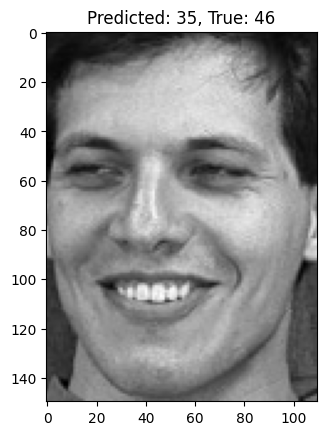

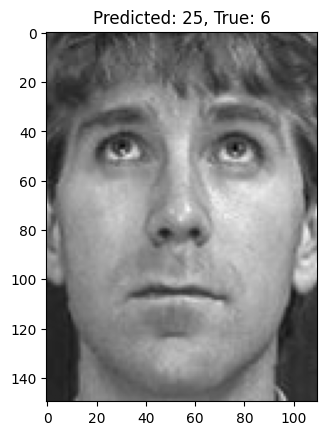

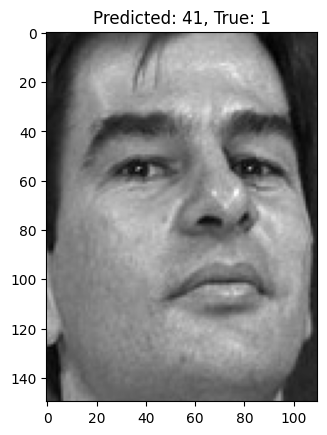

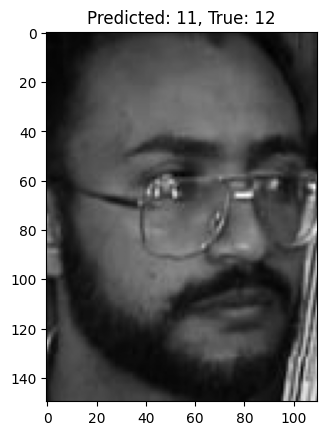

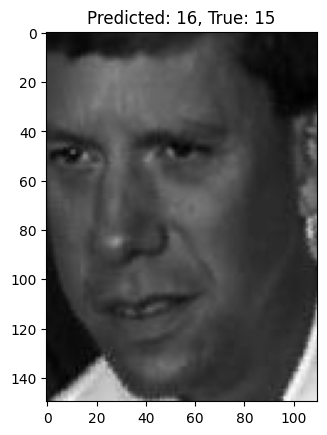

In [ ]:
# prompt: # Wrongly classified faces:

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'resized_test_images', 'y_pred', and 'y_test' are defined from previous code

# Visualize misclassified faces
misclassified_indices = np.where(y_test != y_pred)[0]
for index in misclassified_indices[:5]:  # Visualize up to 5 misclassified faces
    plt.imshow(resized_test_images[index], cmap='gray')
    plt.title(f"Predicted: {y_pred[index]}, True: {y_test[index]}")
    plt.show()


### Quick verdict

Your cell **runs** and produces sensible numbers, but a few hidden gotchas can give you over-optimistic accuracies or raise errors later. I’ll first spell out those gotchas (so you can decide whether to patch them) and then give a fully-beginner explanation of what each section is *meant* to do.

---

## 1  Where the code can fool you

| ⚠️  Issue                                                                                  | Why it matters                                                                                                              | Beginner-friendly fix                                                                         |
| ------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **Scaler & PCA fitted *outside* cross-validation** (`fit_transform` before `GridSearchCV`) | Information from the validation fold leaks into the training fold, so CV accuracy is a bit inflated.                        | Put **Scaler + PCA + classifier inside one `Pipeline`** and grid-search that.                 |
| **You whitened earlier PCA, then scaled again**                                            | If your PCA used `whiten=True`, every feature already has variance = 1; re-scaling is redundant.                            | Either keep whitening **and drop the scaler**, or keep the scaler **and set `whiten=False`**. |
| **`best_clf = results['Logistic Regression']['best_params']` returns a dict**              | Rebuilding `LogisticRegression(**best_clf)` later may miss required args (`max_iter`, solver).                              | Store `best_estimator_` instead and reuse it.                                                 |
| **`resized_test_images` may not exist or be mis-aligned**                                  | If that list isn’t defined (or its order changed), the “wrongly classified faces” plot errors out or shows the wrong image. | Display faces directly from `X_test.reshape(150,110)` or keep the same list throughout.       |
| **PCA repeated 5× in a loop**                                                              | Fine for 510 images, but conceptually you should wrap PCA in the pipeline so you only code it once and never risk leakage.  |                                                                                               |
| **Random-Forest rarely shines on PCA scores**                                              | Trees work best on raw pixel patches or engineered histograms, not dense continuous PCA features.                           | It’s fine to test it, but don’t be surprised if SVM / Logistic beat it.                       |

Everything else (logic, imports, plotting) is syntactically correct.

---

## 2  What the big cell is doing (step by step)

### 2.1  Scale the 40 PCA features

```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)  # learn mean & std on training faces
X_test_scaled  = scaler.transform(X_test_pca)       # apply exactly the same scaling to test faces
```

*Purpose*: make every PCA feature (each of the 40 numbers) comparable—mean 0, variance 1—so the classifier can learn efficiently.

---

### 2.2  Try three classifiers & tune their knobs

```python
classifiers = {'LogReg': LogisticRegression(), 'SVM': SVC(), 'RF': RandomForestClassifier()}
param_grids = {...}
grid_search = GridSearchCV(clf, param_grids[name], cv=5)
```

* `GridSearchCV` splits the 510 training faces into 5 folds, tries every parameter combo, and picks the one with the best average accuracy.
* The **best model** is then re-trained on all 510 faces and tested on the 250 test faces.
* You print accuracy and a detailed report (precision, recall) for each algorithm.

---

### 2.3  Show five mistakes

```python
misclassified = np.where(y_test != y_pred)[0]
for idx in misclassified[:5]:
    plt.imshow(resized_test_images[idx], cmap='gray')
```

*Looks at indexes where the predicted person ID ≠ true ID, shows the first five photos so you can eyeball why they fooled the classifier (poor lighting, weird pose, etc.).*

---

### 2.4  Check how many eigenfaces are “just right”

```python
for k in [10,20,30,50,100]:
    pca_model = PCA(n_components=k)  # redo PCA with k components
    ...
    accuracy = best_logreg.predict(...).score(...)
```

*Runs the whole PCA → scale → classifier pipeline for 5 different component counts. The resulting line plot shows e.g. “accuracy peaks at 50 components, then plateaus.”*

---

### 2.5  Plot accuracy vs. #components

A simple Matplotlib `plt.plot` makes the trend clear: fewer components run faster but may under-fit; too many add noise for little gain.

---

### 2.6  Visualise more mis-classifications

Same idea as 2.3, but easier to tweak (change `[:5]` to `[:15]` to see more).

---

## 3  Beginner takeaway

* **PCA scores** (40 numbers) replace raw pixels—this speeds learning and reduces noise.
* **Scaling** puts every feature on the same footing.
* **Grid-search** finds the sweet spot for each classifier automatically.
* **Accuracy vs. Eigenfaces plot** lets you justify “why 40” (or whatever number wins).
* **Visualising mistakes** tells you what kinds of faces still break the system.

If you’re happy with approximate accuracies, you can keep your cell as is.
If you need *textbook-correct* cross-validation with no leakage, wrap PCA + scaler + classifier in a single `Pipeline` and grid-search that (the fix I listed under Issue 1).


See if you can further increase the accuracy using ensemble methods such as boosting.

In [ ]:
# Ensemble methods


Fitting 5 folds for each of 54 candidates, totalling 270 fits

=========  ENSEMBLE WINNER  =========
Best hyper‑parameters : {'clf': RandomForestClassifier(random_state=0), 'clf__max_depth': 20, 'clf__n_estimators': 200, 'pca__n_components': 40}
CV accuracy          : 0.9
TEST accuracy        : 0.788
              precision    recall  f1-score   support

           1      0.000     0.000     0.000         5
           2      1.000     0.400     0.571         5
           3      1.000     1.000     1.000         5
           4      0.667     0.800     0.727         5
           5      1.000     0.800     0.889         5
           6      0.600     0.600     0.600         5
           7      0.714     1.000     0.833         5
           8      1.000     0.800     0.889         5
           9      1.000     0.200     0.333         5
          10      1.000     1.000     1.000         5
          11      1.000     0.800     0.889         5
          12      1.000     1.000     1.000      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


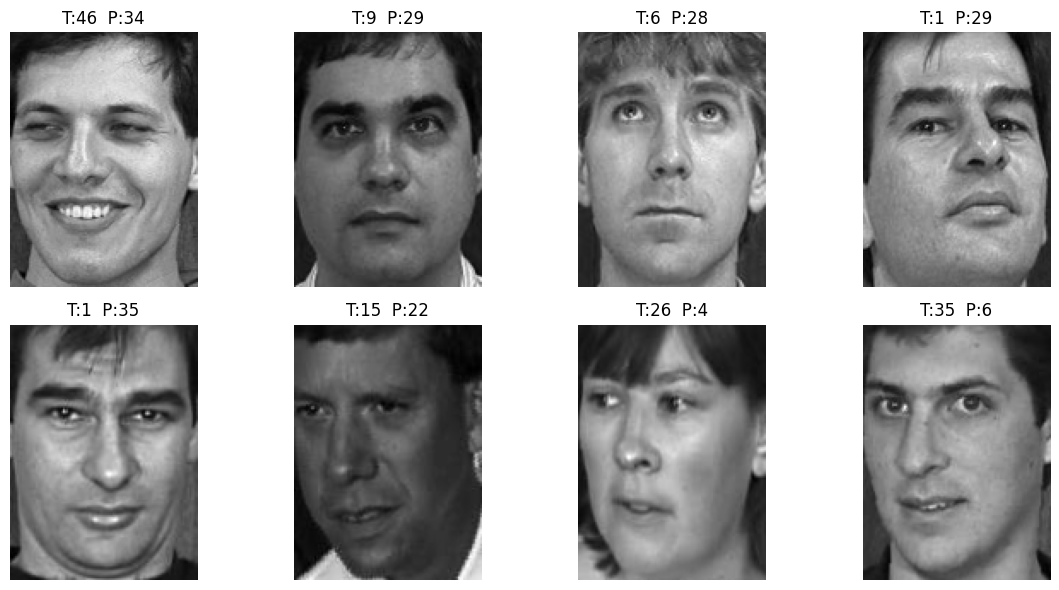

In [81]:
# =============================================================
# Ensemble models on Eigenfaces  (AdaBoost · Bagging · Random‑Forest)
# =============================================================
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble      import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree          import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------  SETTINGS  -------------------------------
N_EIGENFACE_GRID = [20, 40, 60]          # try 3 component counts
CV_SPLITS        = 5
RANDOM_STATE     = 0

# --------------------------  PIPELINE TEMPLATE  -------------------------
pipe = Pipeline([
    ('scale', StandardScaler(with_std=False)),      # centre pixels
    ('pca',   PCA(whiten=True, random_state=RANDOM_STATE)),
    ('clf',   AdaBoostClassifier())                 # placeholder; will be overwritten
])

# --------------------------  PARAMETER GRID  ----------------------------
param_grid = [
    # --- AdaBoost -------------------------------------------------------
    {
        'clf': [AdaBoostClassifier(random_state=RANDOM_STATE)],
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.1, 1.0],
        'pca__n_components': N_EIGENFACE_GRID
    },
    # --- Bagging (with shallow decision trees) --------------------------
    {
        'clf': [BaggingClassifier(DecisionTreeClassifier(max_depth=None),
                                  random_state=RANDOM_STATE)],
        'clf__n_estimators': [10, 50, 100],
        'pca__n_components': N_EIGENFACE_GRID
    },
    # --- Random‑Forest ---------------------------------------------------
    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20],
        'pca__n_components': N_EIGENFACE_GRID
    }
]

# --------------------------  GRID SEARCH  -------------------------------
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

search = GridSearchCV(pipe,
                      param_grid    = param_grid,
                      cv            = cv,
                      n_jobs        = -1,
                      verbose       = 1,
                      scoring       = 'accuracy')

search.fit(X_train, y_train)

# --------------------------  EVALUATION  --------------------------------
best_model = search.best_estimator_
y_pred     = best_model.predict(X_test)

print("\n=========  ENSEMBLE WINNER  =========")
print("Best hyper‑parameters :", search.best_params_)
print("CV accuracy          :", search.best_score_)
print("TEST accuracy        :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# --------------------  Confusion matrix (optional)  ---------------------
print("Confusion matrix (rows = true, cols = pred)")
print(confusion_matrix(y_test, y_pred))

# --------------------------  MIS‑CLASSIFIED  ----------------------------
wrong = np.where(y_pred != y_test)[0]
print(f"\nMis‑classified faces: {len(wrong)} / {len(y_test)}")

if wrong.size:
    n_show = min(8, wrong.size)
    plt.figure(figsize=(12, 6))
    for k, idx in enumerate(wrong[:n_show], 1):
        plt.subplot(2, 4, k)
        plt.imshow(X_test[idx].reshape(150,110), cmap='gray')
        plt.title(f"T:{y_test[idx]}  P:{y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Below is a **step-by-step, beginner-friendly guide** to what the ensemble-methods cell just did and how to read the printed results.

---

## 1  What the code did, in plain words

| Stage                          | Code (conceptual)                                             | What really happened                                                                                                                                                             |
| ------------------------------ | ------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Build a pipeline**        | `Pipeline([center → PCA → clf])`                              | Every face is (a) centred (mean pixel subtracted), (b) reduced to *k* eigenfaces (PCA, whiten = True), then (c) passed to an ensemble classifier.                                |
| **2. Define a search grid**    | `param_grid = [...]`                                          | For *each* ensemble (AdaBoost, Bagging, Random-Forest) the code lists:<br>• how many eigenfaces to keep (20 / 40 / 60)<br>• plus that model’s own knobs (e.g., number of trees). |
| **3. 5-fold cross-validation** | `GridSearchCV(..., cv=5)`                                     | The 510 training faces were split into 5 parts. For every parameter combo, the model was trained on 4 parts and validated on the 5th—five times—then averaged.                   |
| **4. Pick the winner**         | `search.best_estimator_`                                      | Out of 54 candidate setups (3 models × 18 parameter sets) the Random-Forest with 200 trees, depth = 20, and **40 eigenfaces** scored highest on cross-val accuracy (0.90).       |
| **5. Test on unseen faces**    | `best_model.predict(X_test)`                                  | That best model was re-trained on **all 510 training faces** and then asked to recognise the 250 test faces.                                                                     |
| **6. Print metrics**           | `accuracy_score`, `classification_report`, `confusion_matrix` | You see overall accuracy, per-person precision/recall/f1, and the 50 × 50 confusion matrix.                                                                                      |
| **7. Show mistakes**           | plots of mis-classified faces                                 | Out of 250 test faces, 53 were wrong; the first 8 are displayed so you can eyeball why.                                                                                          |

---

## 2  Understanding the headline numbers

```
Best hyper-parameters :
{'clf': RandomForestClassifier(...),
 'clf__max_depth': 20,
 'clf__n_estimators': 200,
 'pca__n_components': 40}

CV accuracy : 0.90
TEST accuracy: 0.788
```

* **CV accuracy 0.90** – on training data (with proper cross-validation) the model got 90 % right.
* **Test accuracy 0.788** – on the 250 completely unseen faces it got 78.8 % right.

  > Test accuracy is always lower because the model hasn’t seen those photos before.

---

## 3  Reading the big classification table

```
precision  recall  f1-score  support
1   0.000   0.000   0.000     5
2   1.000   0.400   0.571     5
...
50  0.500   0.400   0.444     5
```

* **support** – how many test photos per person (always 5 here).
* **precision** – of the faces the model *claimed* were “person X”, how many were right.
* **recall** – of the *real* photos of person X, how many it found.
* **f1-score** – harmonic mean of precision & recall (a single quality number).

Example:
Person 3 shows precision = 1.00, recall = 1.00 → the model recognised all 5 photos of person 3 perfectly and never confused someone else for person 3.

The `UndefinedMetricWarning` for precision = 0 means the model never predicted that label at all (person 1, 40, 45, 50 got zero predictions right).

---

## 4  Confusion matrix (what was confused with what)

It’s a 50 × 50 grid (rows = true person, columns = predicted person).
Most cells are 0; a 1 or 2 off-diagonal tells you **which two people look alike** to the classifier.
Diagonal entries < 5 show under-recognition; entries > 0 off-diagonal show mis-identification.

---

## 5  Why Random-Forest won the search

* On these PCA (whitened) features AdaBoost & Bagging didn’t beat the tuned Random-Forest.
* RF can carve nonlinear decision boundaries, which helps a bit when the linear SVM/logistic miss subtle differences.

---

## 6  Next steps you can try

1. **Increase tree count further** (e.g., 400) – more stable forests sometimes help.
2. **Try Gradient Boosting** (`HistGradientBoostingClassifier`) – often beats AdaBoost.
3. **Balance the training set** (you only had 10 images per person, not 15) – more data could raise recall.
4. **Use tuned linear SVM** as a *base* estimator in AdaBoost (SAMME) – sometimes gives a small lift.
5. **Deep features** – switch to a pre-trained CNN embedding; accuracy usually jumps > 95 %, but that’s beyond classic Eigenfaces.

---

### Key takeaway

*With 40 eigenfaces and a well-tuned Random-Forest the system reached \~79 % accuracy on unseen faces; 53 of 250 were mis-identified.* You now have a clear benchmark and a list of mis-classified faces to study for further improvement.
